0. IMPORTS

In [115]:
import pandas as pd
import inflection
import math
import datetime
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from plotly                import express as px
from matplotlib            import gridspec
from IPython.display       import Image
from IPython.core.display  import HTML
from matplotlib.gridspec   import GridSpec
from scipy                 import stats


1. HELPER FUNCTIONS

In [ ]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    %matplotlib inline
    plt.style.use ('bmh')
    plt.rcParams['figure.figsize'] = [25,12] #os gráficos ja ficam do tamanho maior
    plt.rcParams['font.size'] = 24
    display(HTML ('<style>.container { width:90% !important; }</style>')) #o jupyter pode ficar sem as margens se colocar 100%
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option ('display.expand_frame_repr', False)
    sns.set()
    
jupyter_settings()

2. LOADING DATA

In [2]:
#read files - sales and locations
df_sales = pd.read_csv('Kaggle-data/train.csv', low_memory=False) #low_memory false faz com que leia todo arquivo de uma vez
df_stores = pd.read_csv('Kaggle-data/store.csv', low_memory=False)

#merge datasets
df_raw = pd.merge(df_sales, df_stores, how ='left', on ='Store')

3. DATA CLEANING

In [3]:
#copy dataset
df1 = df_raw.copy()

#rename columns
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

#build function 
snakecase = lambda x: inflection.underscore(x)
#apply function in cols_old
cols_new = list(map(snakecase, cols_old))
#rename
df1.columns = cols_new

#data dimensions
li = df1.shape[0]
co = df1.shape[1]
print(f'The number of rows is {li}')
print(f'The number of columns is {co}')

#data types
df1.dtypes
df1['date'] = pd.to_datetime(df1['date'], format = '%Y-%m-%d')

#check na
df1.isna().sum()

The number of rows is 1017209
The number of columns is 18


store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [4]:
#fillout na

#competition_distance
#it was considered that if it is na, it has no close competition. So distance was filled with a high value 
df1['competition_distance'] = df1['competition_distance'].apply (lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
#filled with sales month date - so it will be as the competition started in the same date as the sale
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)


#competition_open_since_year
#filled with sales date - so it will be as the competition started in the same date as the sale
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

#promo2_since_week
#filled with sales date - so it will be as the promo2 started in the same date as the sale
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

#promo2_since_year
#filled with sales date - so it will be as the promo2 started in the same date as the sale
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

#promo_interval
df1['promo_interval'].fillna(0, inplace= True)

#promo now
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12: 'Dec'} 
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['promo_now'] = df1[['promo_interval','month_map']].apply (lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [5]:
#change types
df1.dtypes

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] =  df1['competition_open_since_year'].astype(int)      
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [7]:
#statistics
df2 = df1.copy()

#numeric data
num_attributes = df2.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df2.select_dtypes(exclude = ['int64', 'float64','datetime64[ns]'])


#central 
df_mean = pd.DataFrame(num_attributes.apply(np.mean))
df_median = pd.DataFrame(num_attributes.apply(np.median))


#dispersions
df_std = pd.DataFrame(num_attributes.apply(np.std))
df_max = pd.DataFrame(num_attributes.apply(max))
df_min = pd.DataFrame(num_attributes.apply(min))
df_range = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min()))
df_skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew()))
df_kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis()))

statistics = pd.concat([df_mean, df_median, df_min, df_max, df_range, df_std, df_skew, df_kurtosis], axis=1).reset_index()
statistics.columns = ['attributes','mean','median','minimum','maximum','range','std','skewness','kurtosis']



statistics

,attributes,mean,median,minimum,maximum,range,std,skewness,kurtosis
0,store,558.429727,558.0,1.0,1115.0,1114.0,321.908493,-0.000955,-1.200524
1,day_of_week,3.998341,4.0,1.0,7.0,6.0,1.997390,0.001593,-1.246873
2,sales,5773.818972,5744.0,0.0,41551.0,41551.0,3849.924283,0.641460,1.778375
3,customers,633.145946,609.0,0.0,7388.0,7388.0,464.411506,1.598650,7.091773
4,open,0.830107,1.0,0.0,1.0,1.0,0.375539,-1.758045,1.090723
5,promo,0.381515,0.0,0.0,1.0,1.0,0.485758,0.487838,-1.762018
6,school_holiday,0.178647,0.0,0.0,1.0,1.0,0.383056,1.677842,0.815154
7,competition_distance,5935.442677,2330.0,20.0,200000.0,199980.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,6.786849,7.0,1.0,12.0,11.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,2010.324840,2012.0,1900.0,2015.0,115.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='assortment', ylabel='sales'>

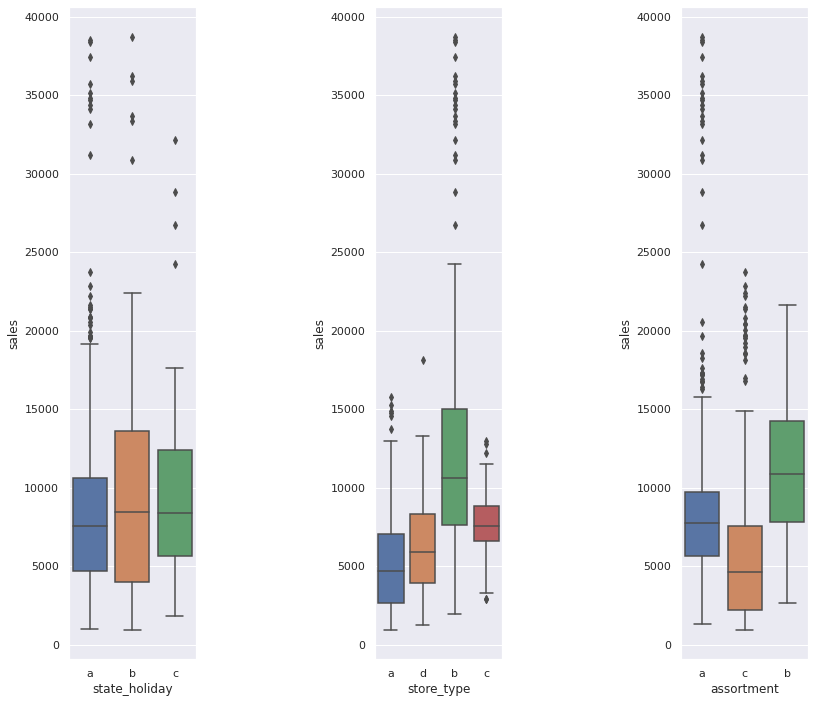

In [8]:
#categorical attributes
aux = df2[(df2['state_holiday'] !='0') & (df2['sales'] > 0)]
   
plt.subplot(1,6,1)
sns.boxplot(x ='state_holiday' , y= 'sales', data = aux)

plt.subplot(1,6,3)
sns.boxplot(x = 'store_type', y = 'sales', data = aux)

plt.subplot(1,6,5)
sns.boxplot(x = 'assortment', y = 'sales', data = aux)

#ponto mais baixo - minimo
#quartil 25 - 25% dos dados estão até este ponto
#quartil 50 - mediana - 50% dos dados estão até este ponto 
#quartil 75 - 75¨% dos dados estão até este ponto


4. DATA CLEANING - FEATURE ENGINEERING

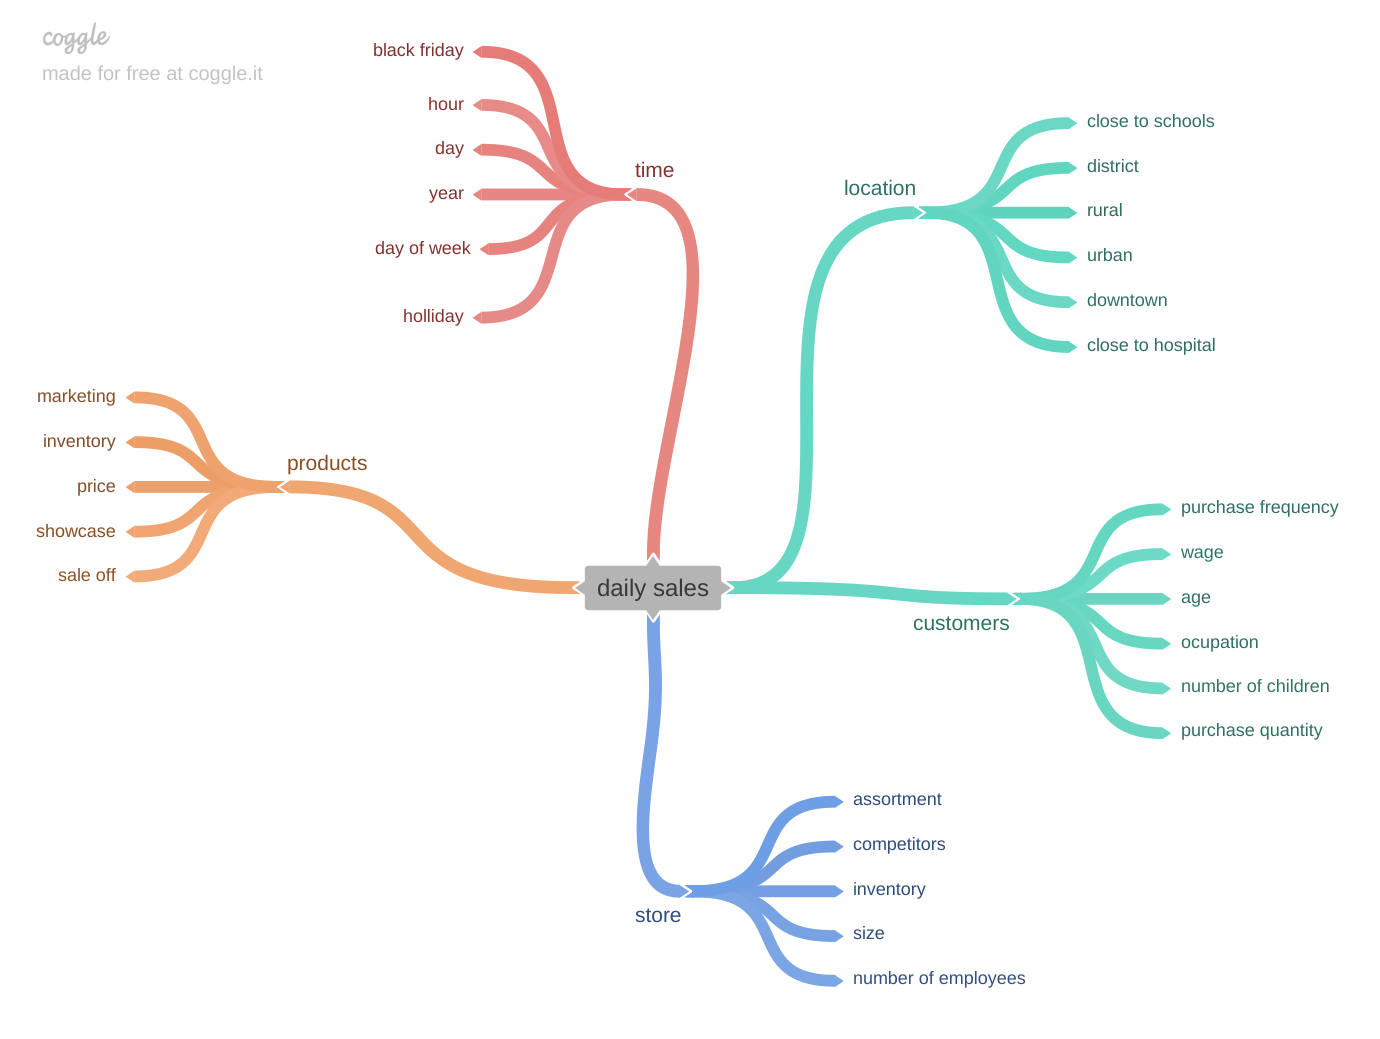

In [9]:
Image('img/mindmap2.png')

In [80]:
df3 = df2.copy()

#year
df3['year'] = df3['date'].dt.year

#month
df3['month'] = df3['date'].dt.month

#day
df3['day'] = df3['date'].dt.day

#week of year
df3['week_of_year'] = df3['date'].dt.isocalendar().week

#year week
df3['year_week'] = df3['date'].dt.strftime('%Y-%W')

#competition since
df3['competition_since'] = df3.apply(lambda x: str(x['competition_open_since_year']) + '-' + str(x['competition_open_since_month']) + '-' + '01', axis=1)
df3['competition_since'] = pd.to_datetime(df3['competition_since'], format = '%Y-%m-%d')
df3['competition_time_days'] = df3.apply(lambda x: x['date'] - x['competition_since'], axis=1)
#transform days into months
df3['competition_time_days'] = df3['competition_time_days'].astype('timedelta64[D]')
df3['competition_time_month'] = df3['competition_time_days']/30
df3['competition_time_month'] = df3['competition_time_month'].astype(int)

#promo since
df3['promo_since'] = df3['promo2_since_year'].astype(str) + '-' + df3['promo2_since_week'].astype(str)
df3['promo_since'] = df3['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df3['promo_time_days'] = df3['date'] - df3['promo_since']
#transform days into weeks
df3['promo_time_days'] = df3['promo_time_days'].astype('timedelta64[D]')
df3['promo_time_weeks'] = df3['promo_time_days']/7
df3['promo_time_weeks'] = df3['promo_time_weeks'].astype(int)

#assortment
df3['assortment'] = df3['assortment'].apply(lambda x: 'basic' if x=='a' else
                                                       'extra' if x=='b' else
                                                        'extended')

#holiday
df3['state_holiday'] = df3['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else
                                                            'easter_holiday' if x=='b' else
                                                            'christmas' if x=='c' else 
                                                            'regular_day' )


4 DATA CLEANING - DATA FILTERING

In [14]:
df4 = df3.copy()
#filter lines
df4 = df4.loc[(df4['open'] != 0) & (df4['sales']>0), :] 

#drop auxiliar columns
cols_drop = ['customers', 'open', 'month_map','competition_since','competition_time_days', 'promo_since', 'promo_time_days']
df4 = df4.drop(cols_drop, axis=1)
#customers - não será usado pois não conseguimos prever o numero de clientes que teremos nas lojas
#open só vai ter 1 aberto, então irrelevante

5. EDA - EXPLORATORY DATA ANALYSIS

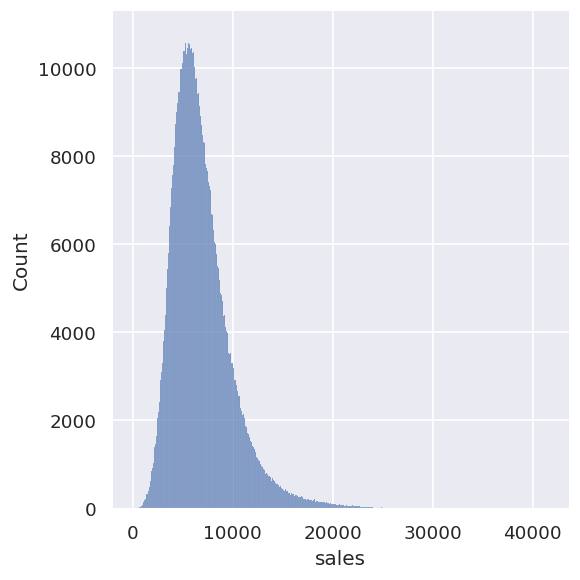

In [63]:
df5 = df4.copy()
#analise univariada
#variavel resposta
#algoritimos de ml tem algumas premissas pra funcionar, como por exemplo que as variaveis devem ser independetes, e normalmente distribuidas
#multiplicar os valores pelo log é um exemplo pra deixar mais normal a distribuição

sns.displot(df5['sales']); 
#sns.displot(np.log1p(df5['sales']))

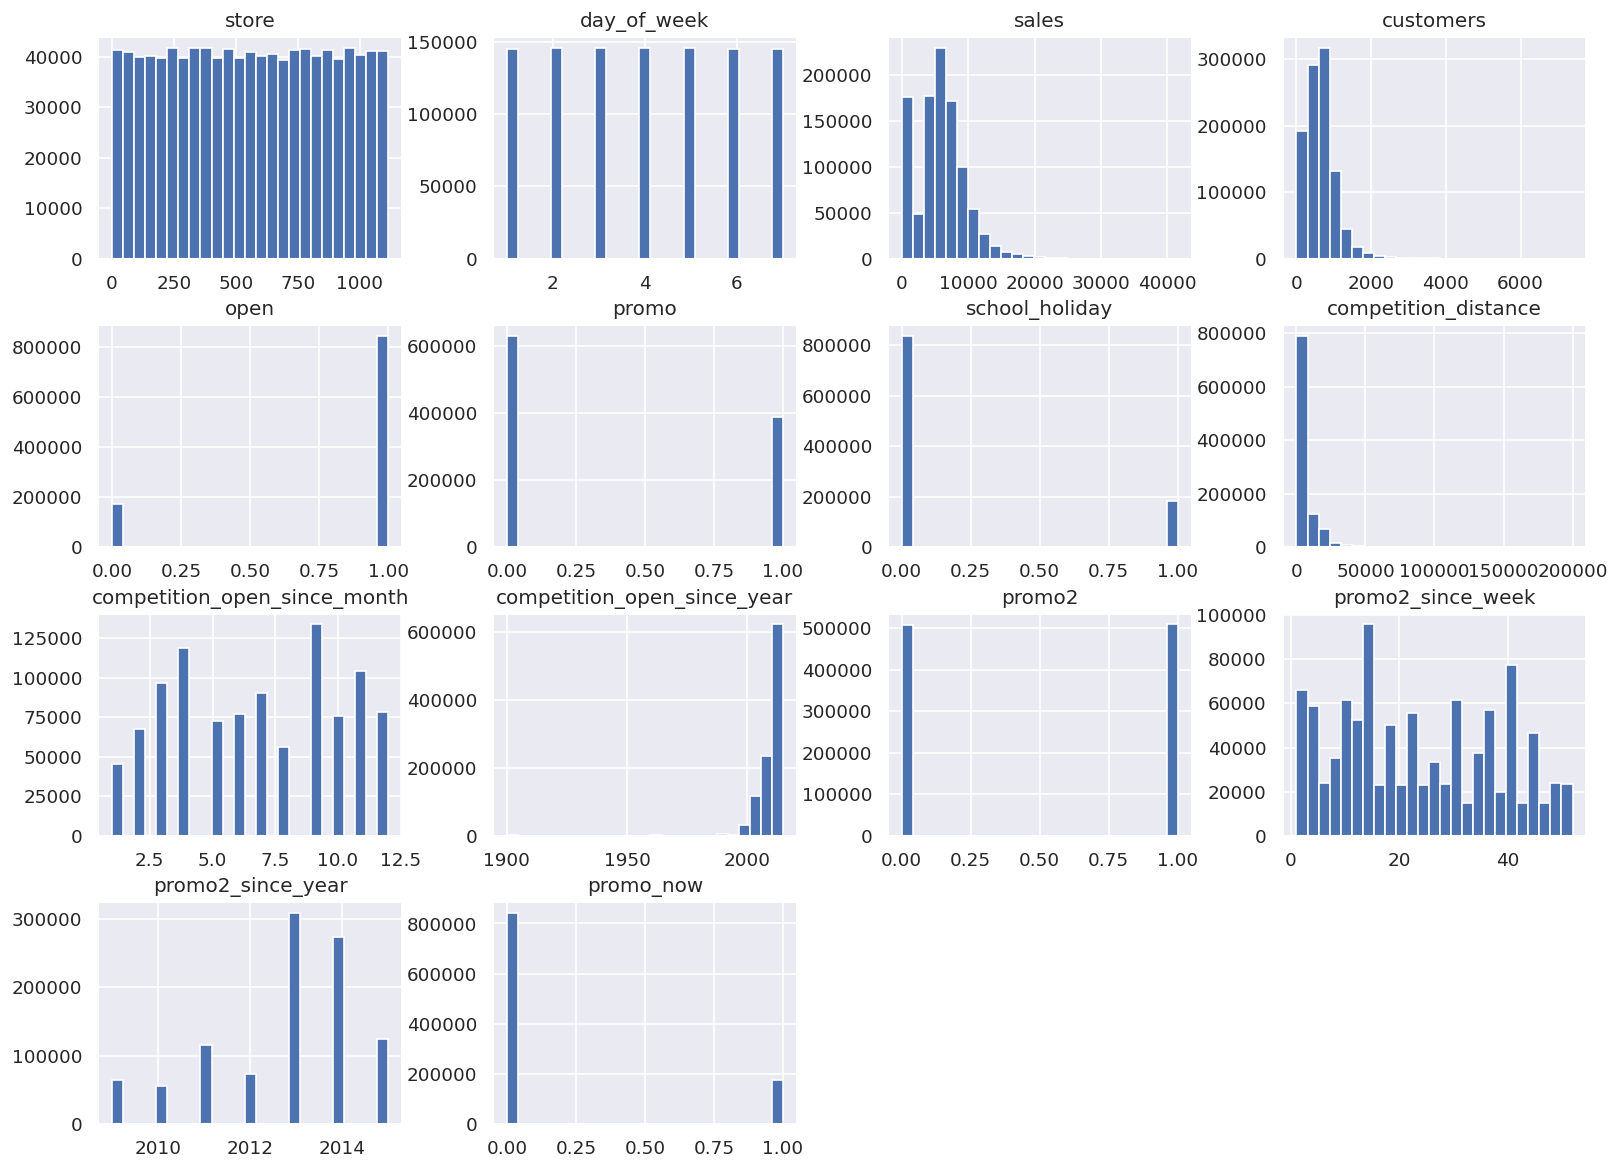

In [17]:

num_attributes.hist(bins=25);

#hitograma
#esse grafico mostra a concentração de cada variavel. um numero de linhas em que cada variavel aparece.
#como cada linha representa uma venda, é relacionado com a venda
#day of week - cada dia da semana aparece cerca de 150.000 vezes nos dados.ou seja, as vendas são igualmente distribuidas nos dias.
#promo - cerca de 600000 vezes encontrou-se 0 em promo, e cerca de 400000 vezes encontrou-se valor 1 em promo. ou seja, mais vendas ocorrem sem promoção.
#promo2sinceyear -mais de 300000 das vendas estão em promoção desde o ano 2013
#competition open since month - mais de 125000 vendas ocorreram em lojas que possuem competição ha 9 anos.


/home/gklin/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/gklin/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/gklin/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

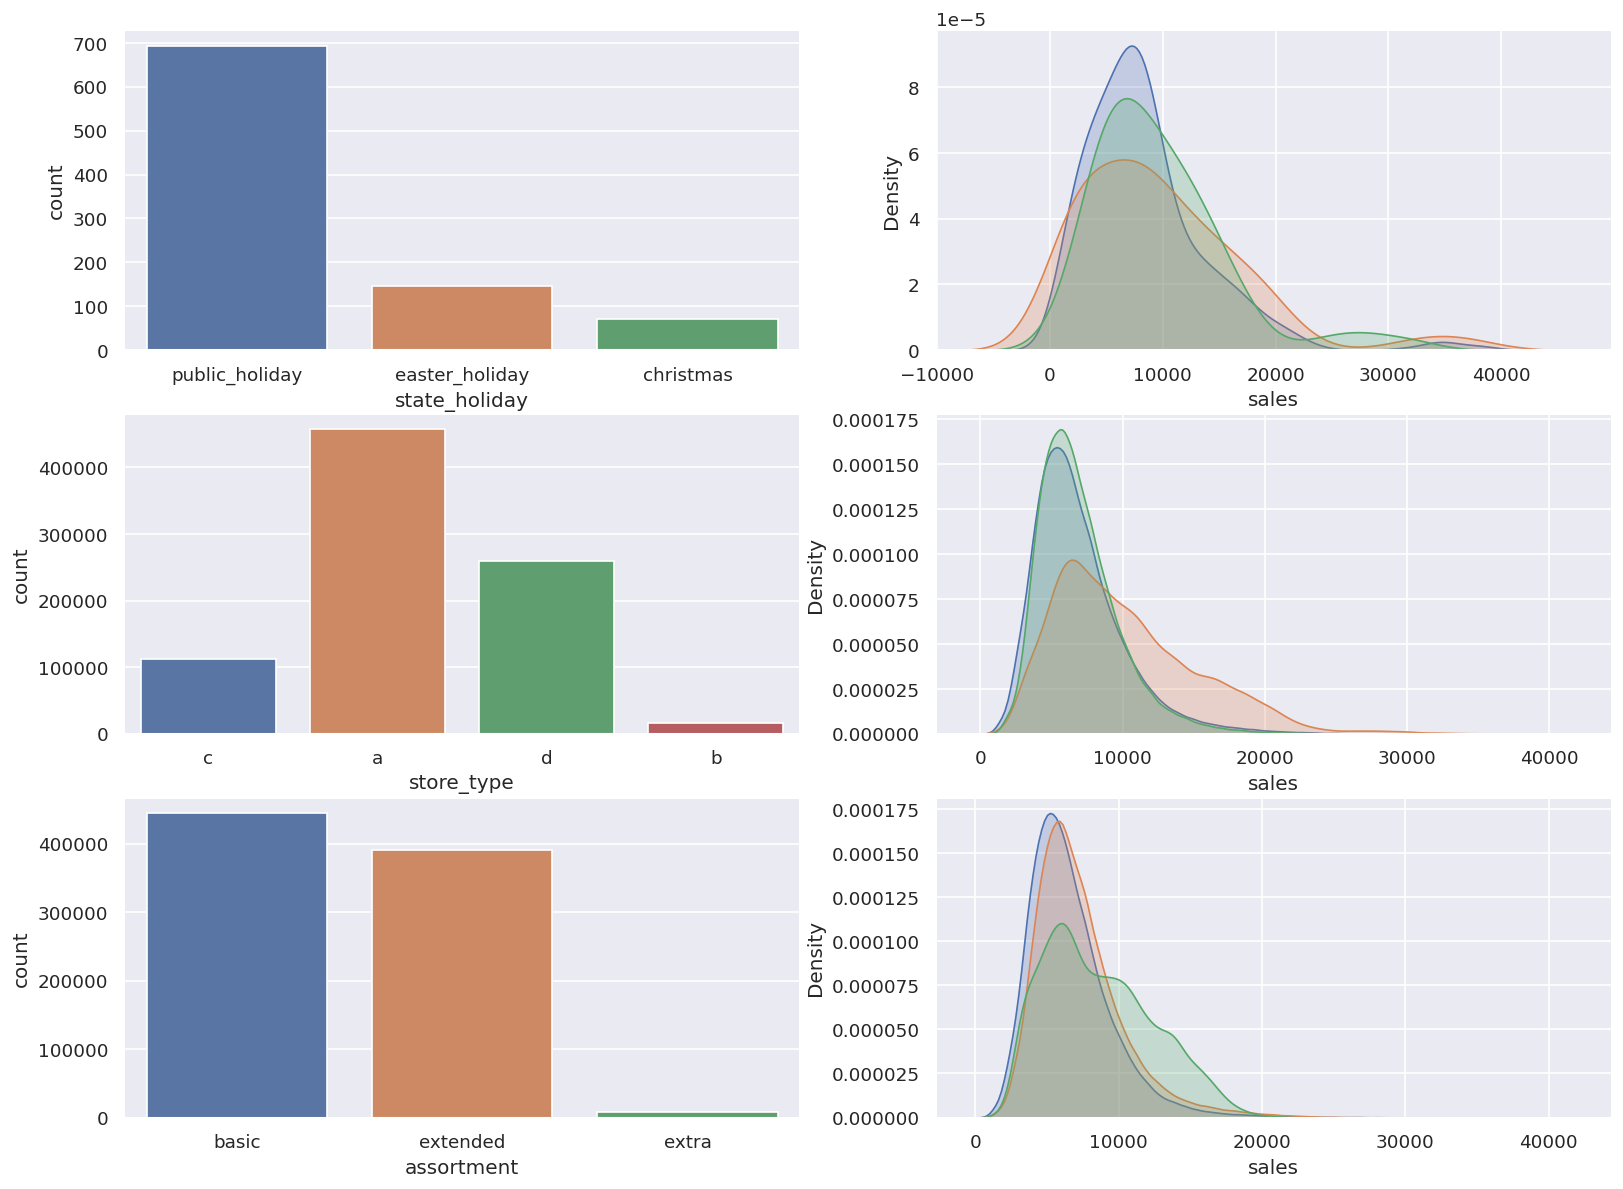

In [19]:
#categorical

#state_holydays
plt.subplot(3,2,1)
a = df5.loc[df5['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df5[df5['state_holiday'] == 'public_holiday']['sales'], label= "public_holiday", shade=True)
sns.kdeplot(df5[df5['state_holiday'] == 'easter_holiday']['sales'], label ='easter_holiday',shade=True)
sns.kdeplot(df5[df5['state_holiday'] == 'christmas']['sales'], label ='christmas', shade=True)


#store_type
plt.subplot(3,2,3)
sns.countplot(df5['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df5[df5['store_type'] == 'a']['sales'], label ='a',shade=True)
sns.kdeplot(df5[df5['store_type'] == 'b']['sales'], label ='b',shade=True)
sns.kdeplot(df5[df5['store_type'] == 'c']['sales'], label ='c', shade=True)

#assortment
plt.subplot(3,2,5)
sns.countplot(df5['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df5[df5['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df5[df5['assortment'] == 'extended']['sales'], label ='extended',shade=True)
sns.kdeplot(df5[df5['assortment'] == 'extra']['sales'], label ='extra', shade=True)

#ver porque labels não aparecem

In [70]:
#analise bivariada
#objetivos: 
#ganhar experiencia de negócio 
#validar hipoteses (trazer surpresa)
#verificar variaveis que serão relevantes por modelo 

**#hypotesis:**

**1)lojas com maior sortimento (extra) vendem mais**

**Falso:** lojas com maior sortimento vendem menos


**2)Lojas com competitoderes mais proximos vendem menos**

**Falso:** lojas com competidores mais próximos vendem mais


**3)lojas com competidores há mais tempo vendem mais**

**Falso:** lojas com competidores há mais tempo vendem menos


**4)lojas compromoççoes ativas por mais tempo deveriam vender mais**

**Falso:** lojas com promoções ativas por mais tempo vendemo menos depois de um certo tempo


**5)lojas com mais promoçoes consecutivas deveriam vender mais**

**Não fiz pq não achei com muito sentido** 

**6)O feriado com mais vendas é o natal**
**Falso:** o feriado com mais vendas não é o natal

**7)Lojas deveriam vender mais ao longo dos anos**
**Falso:** lojas venderam menos ao longo dos anos

**8)Lojas deveriam vender mais no segundo semestre do ano**
**Falso:** Lojas vendem menos no segundo semestre

**9)Lojas deveriam vender mais conforme o mes vai passando**
**Falso:** Lojas vendem menos conforme o mes vai passando

**10)Lojas deveriam vender menos nos finais de semana**
**Verdadeiro:** Lojas vendem menos nos finais de semana

**11)Lojas deveriam vender menos durante feriados escolares**
**Verdadeiro:** Lojas vendem menos durando os feriados escolares, exceto no mes agosto

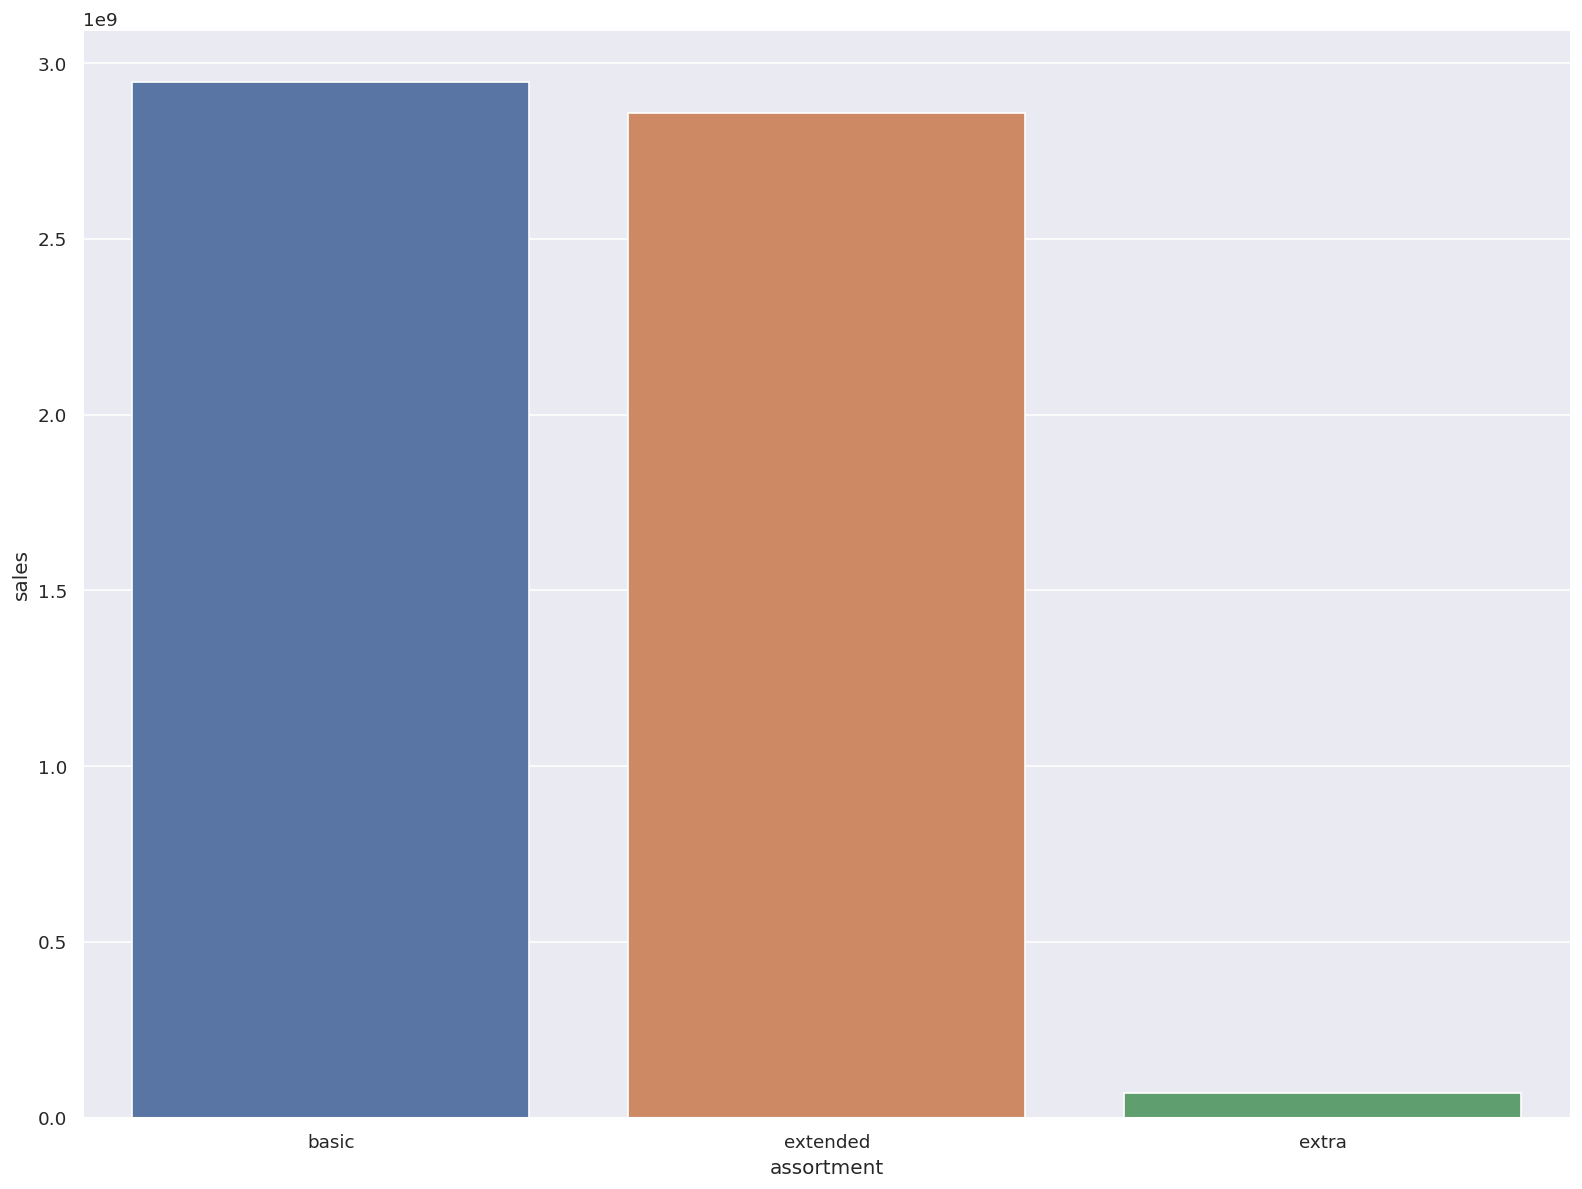

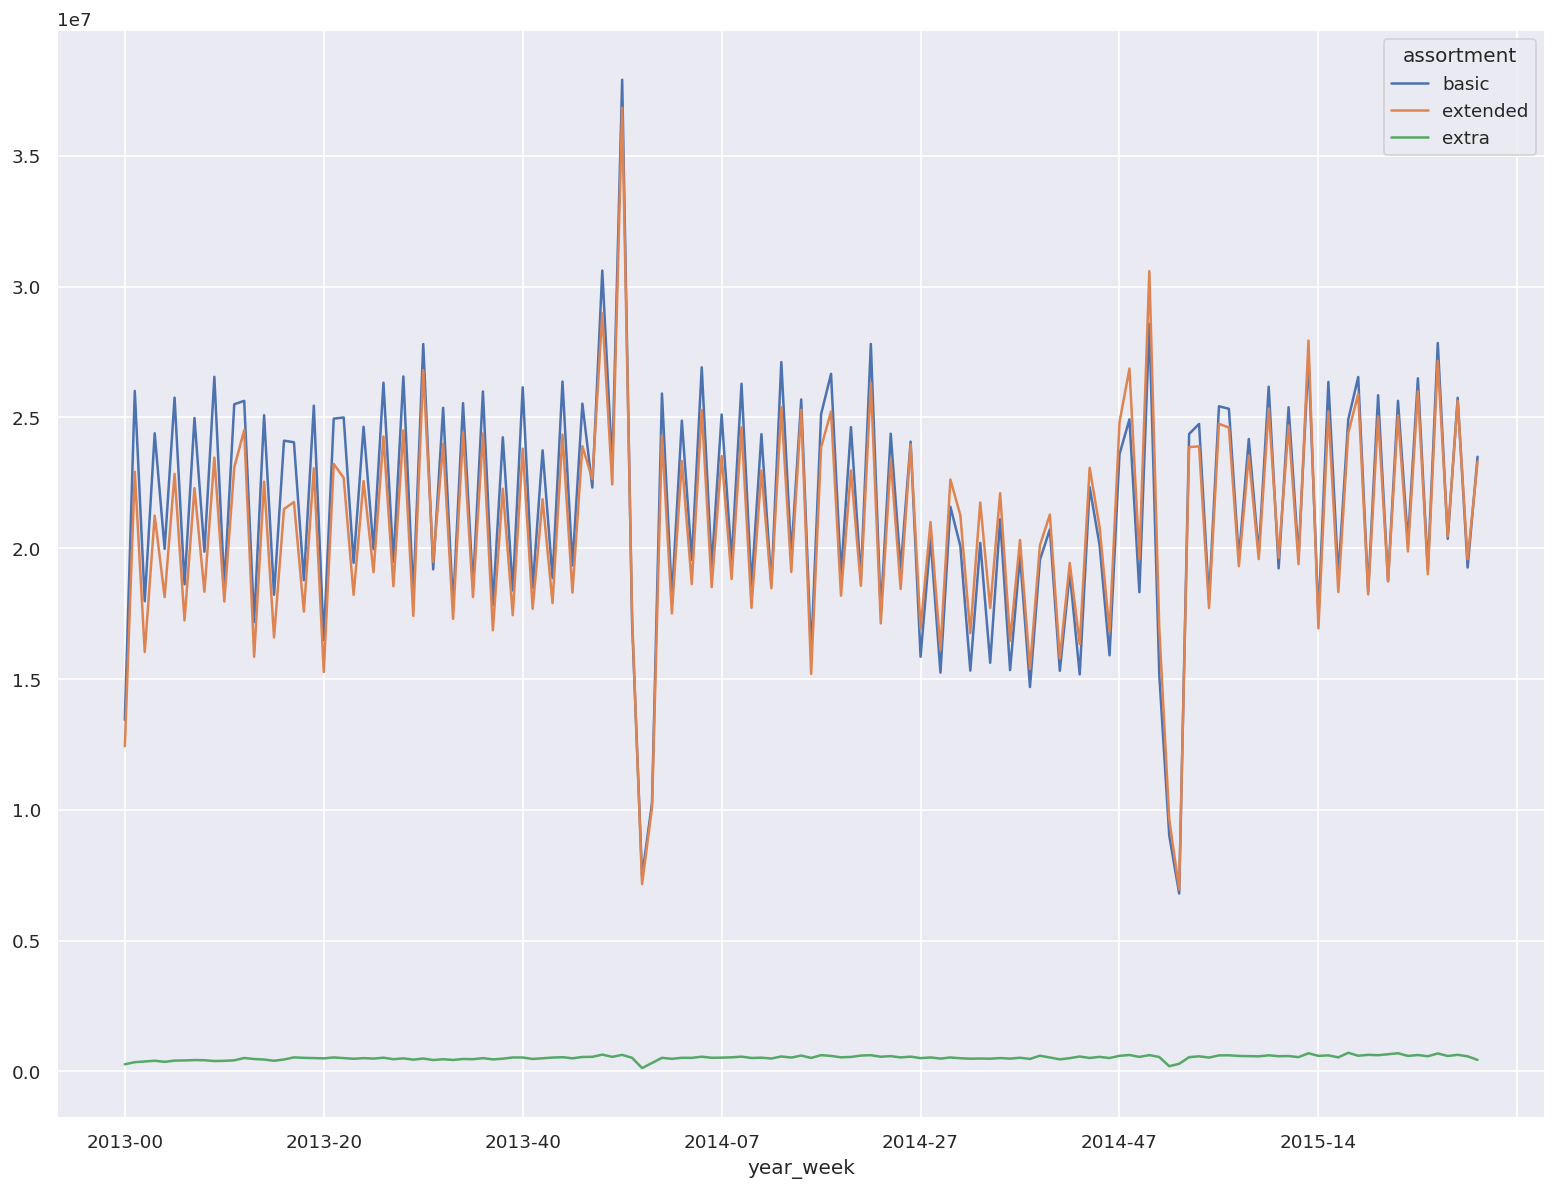

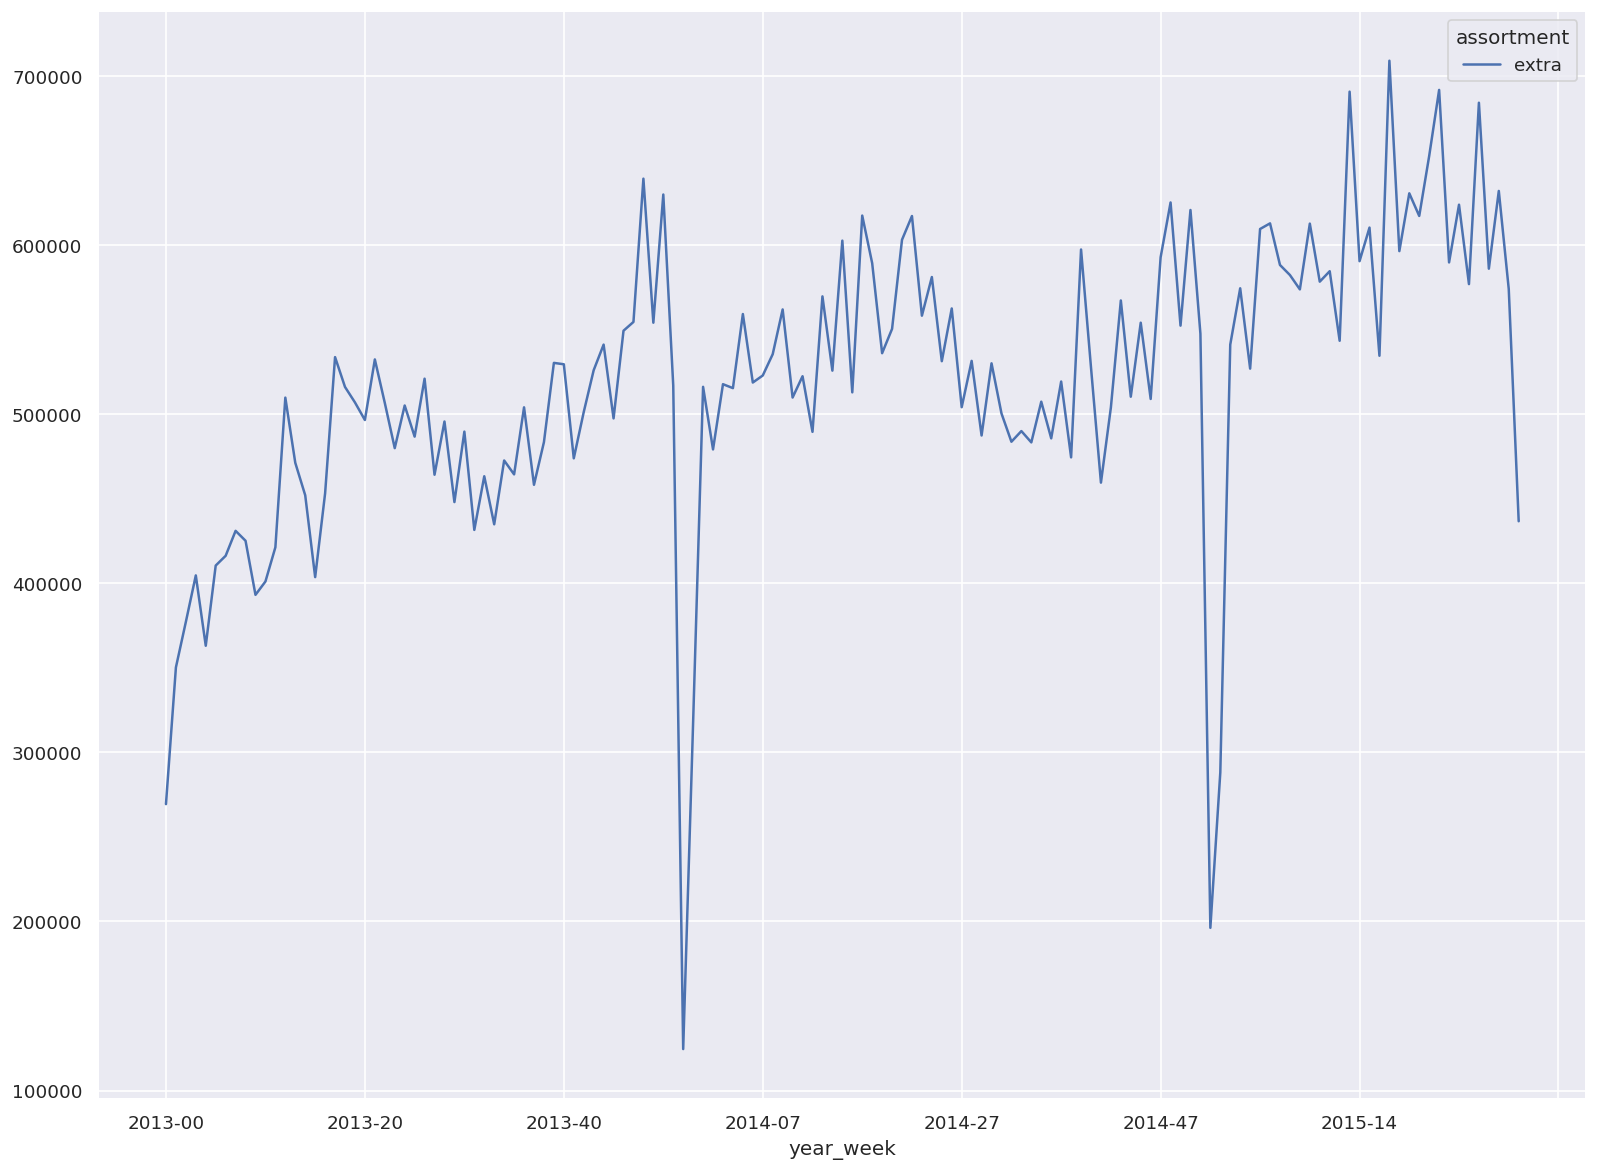

In [21]:
#lojas com maior sortimento (extra) vendem mais

aux1 = df5[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data =aux1 )

assort_sales = df5[['assortment', 'sales','year_week']].groupby(['year_week','assortment']).sum().reset_index()
assort_sales.pivot(index ='year_week', columns = 'assortment', values='sales').plot();

extra = assort_sales.loc[assort_sales['assortment'] == 'extra']
extra.pivot(index ='year_week', columns = 'assortment', values='sales').plot();

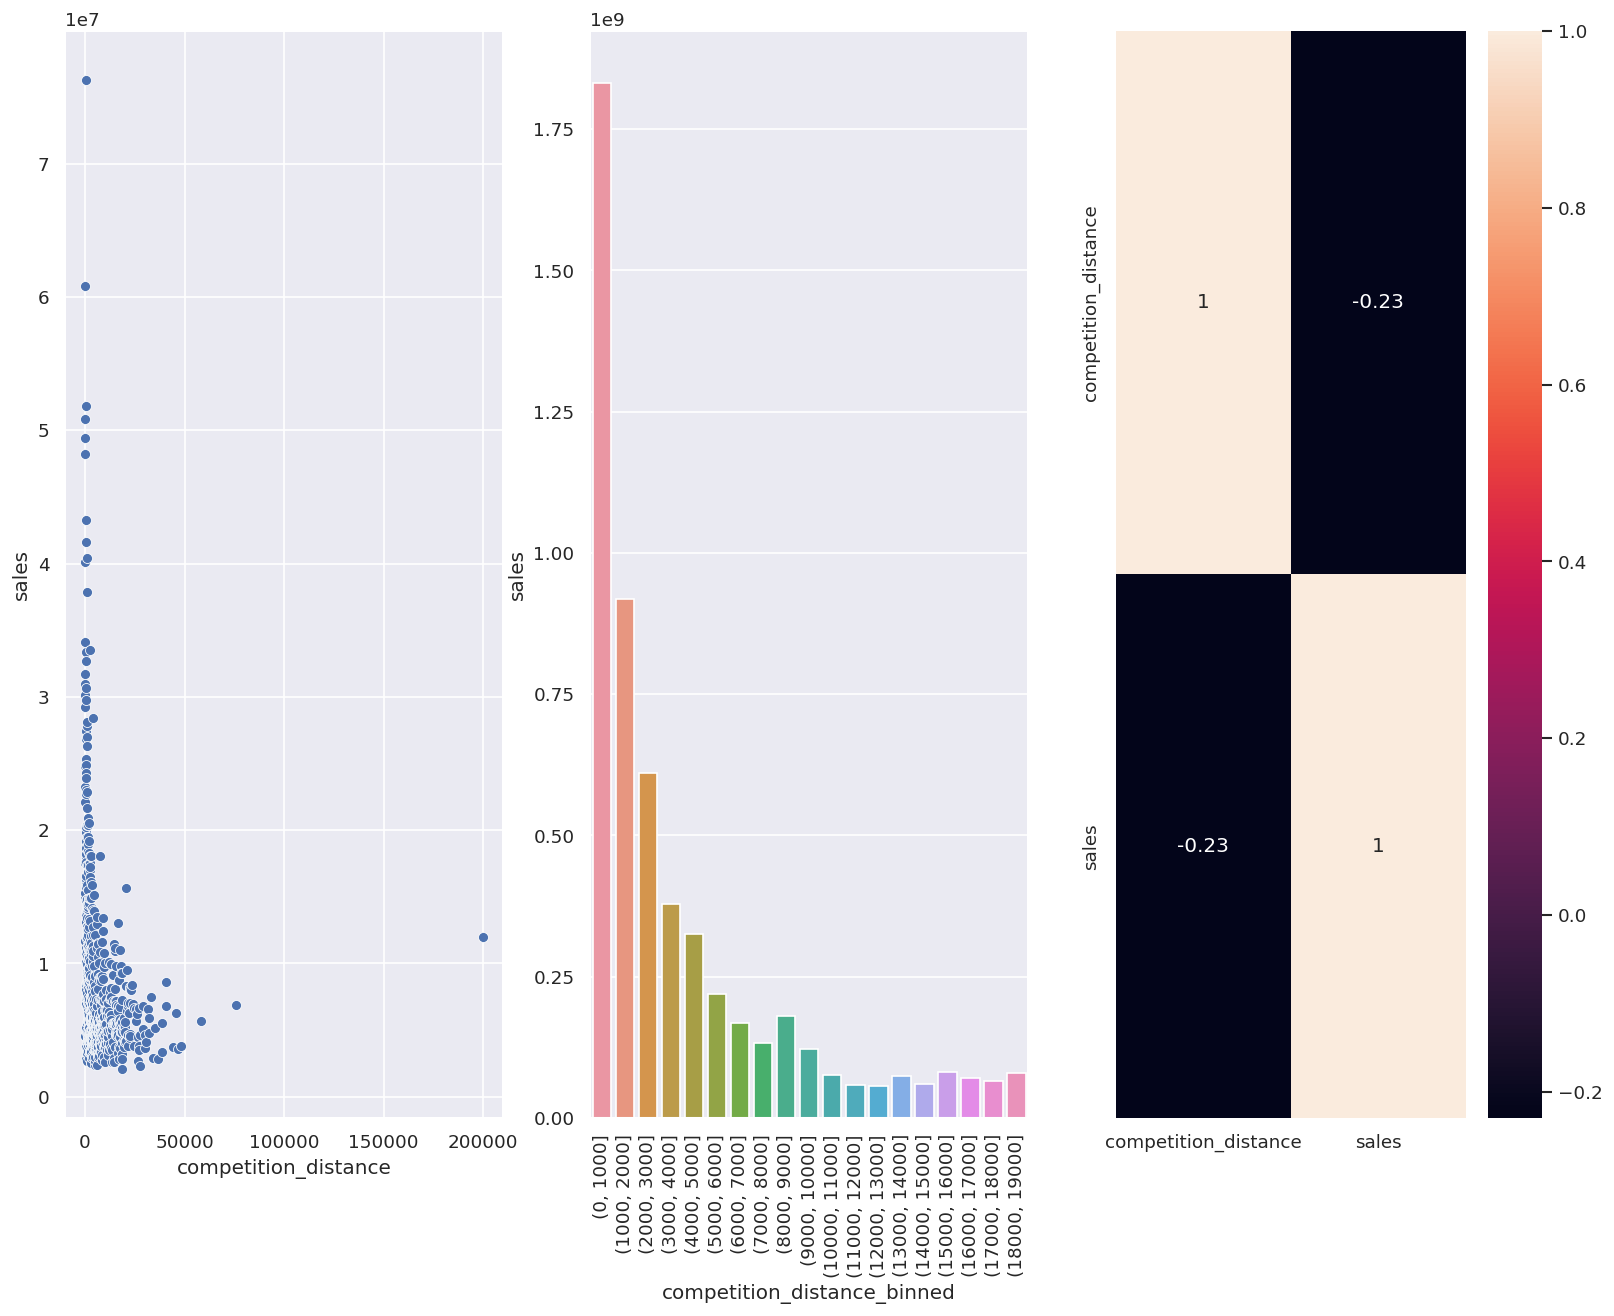

In [22]:
#lojas com competidores mais próximos vendem menos
#Falso: lojas com competidores mais próximos vendem mais

#dispersion graph
aux1 = df5[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y='sales', data = aux1)

#histogram
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['sales','competition_distance_binned']].groupby('competition_distance_binned').sum().reset_index()
plt.subplot(1,3,2)
sns.barplot(x='competition_distance_binned', y ='sales', data = aux2);
plt.xticks(rotation=90);

#correlation
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);
#quanto mais proximo de 1, maior a correlação
# -0.23 correlação negativa - quanto maior a distancia do concorrente, menor a venda



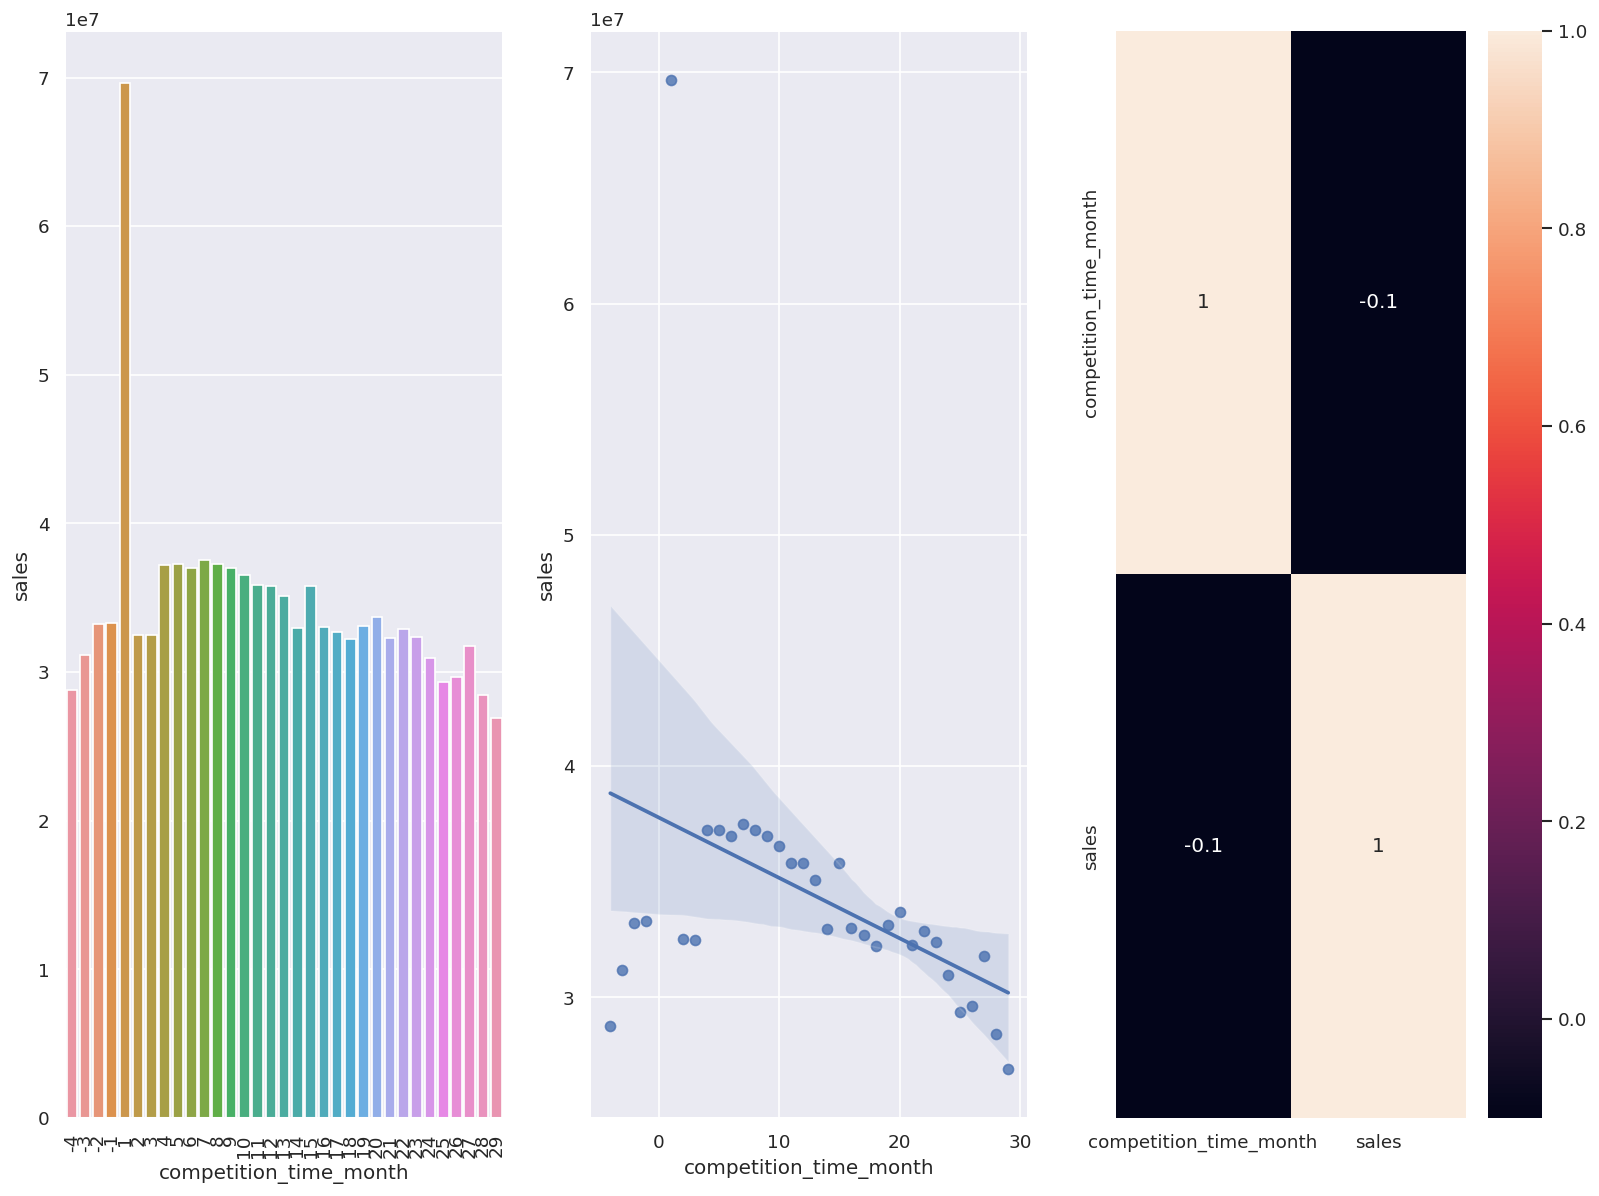

In [23]:
#3)lojas com competidores há mais tempo vendem mais
#Falso: lojas com competidores há mais tempo vendem menos

#lojas com competidores a mais tempo vendem mais
aux1 = df5[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1.loc[(aux1['competition_time_month'] <30) &(aux1['competition_time_month'] >-5) & (aux1['competition_time_month'] != 0 )]

plt.subplot(1,3,1)
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(1,3,2)
sns.regplot(x= 'competition_time_month', y='sales' , data = aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);


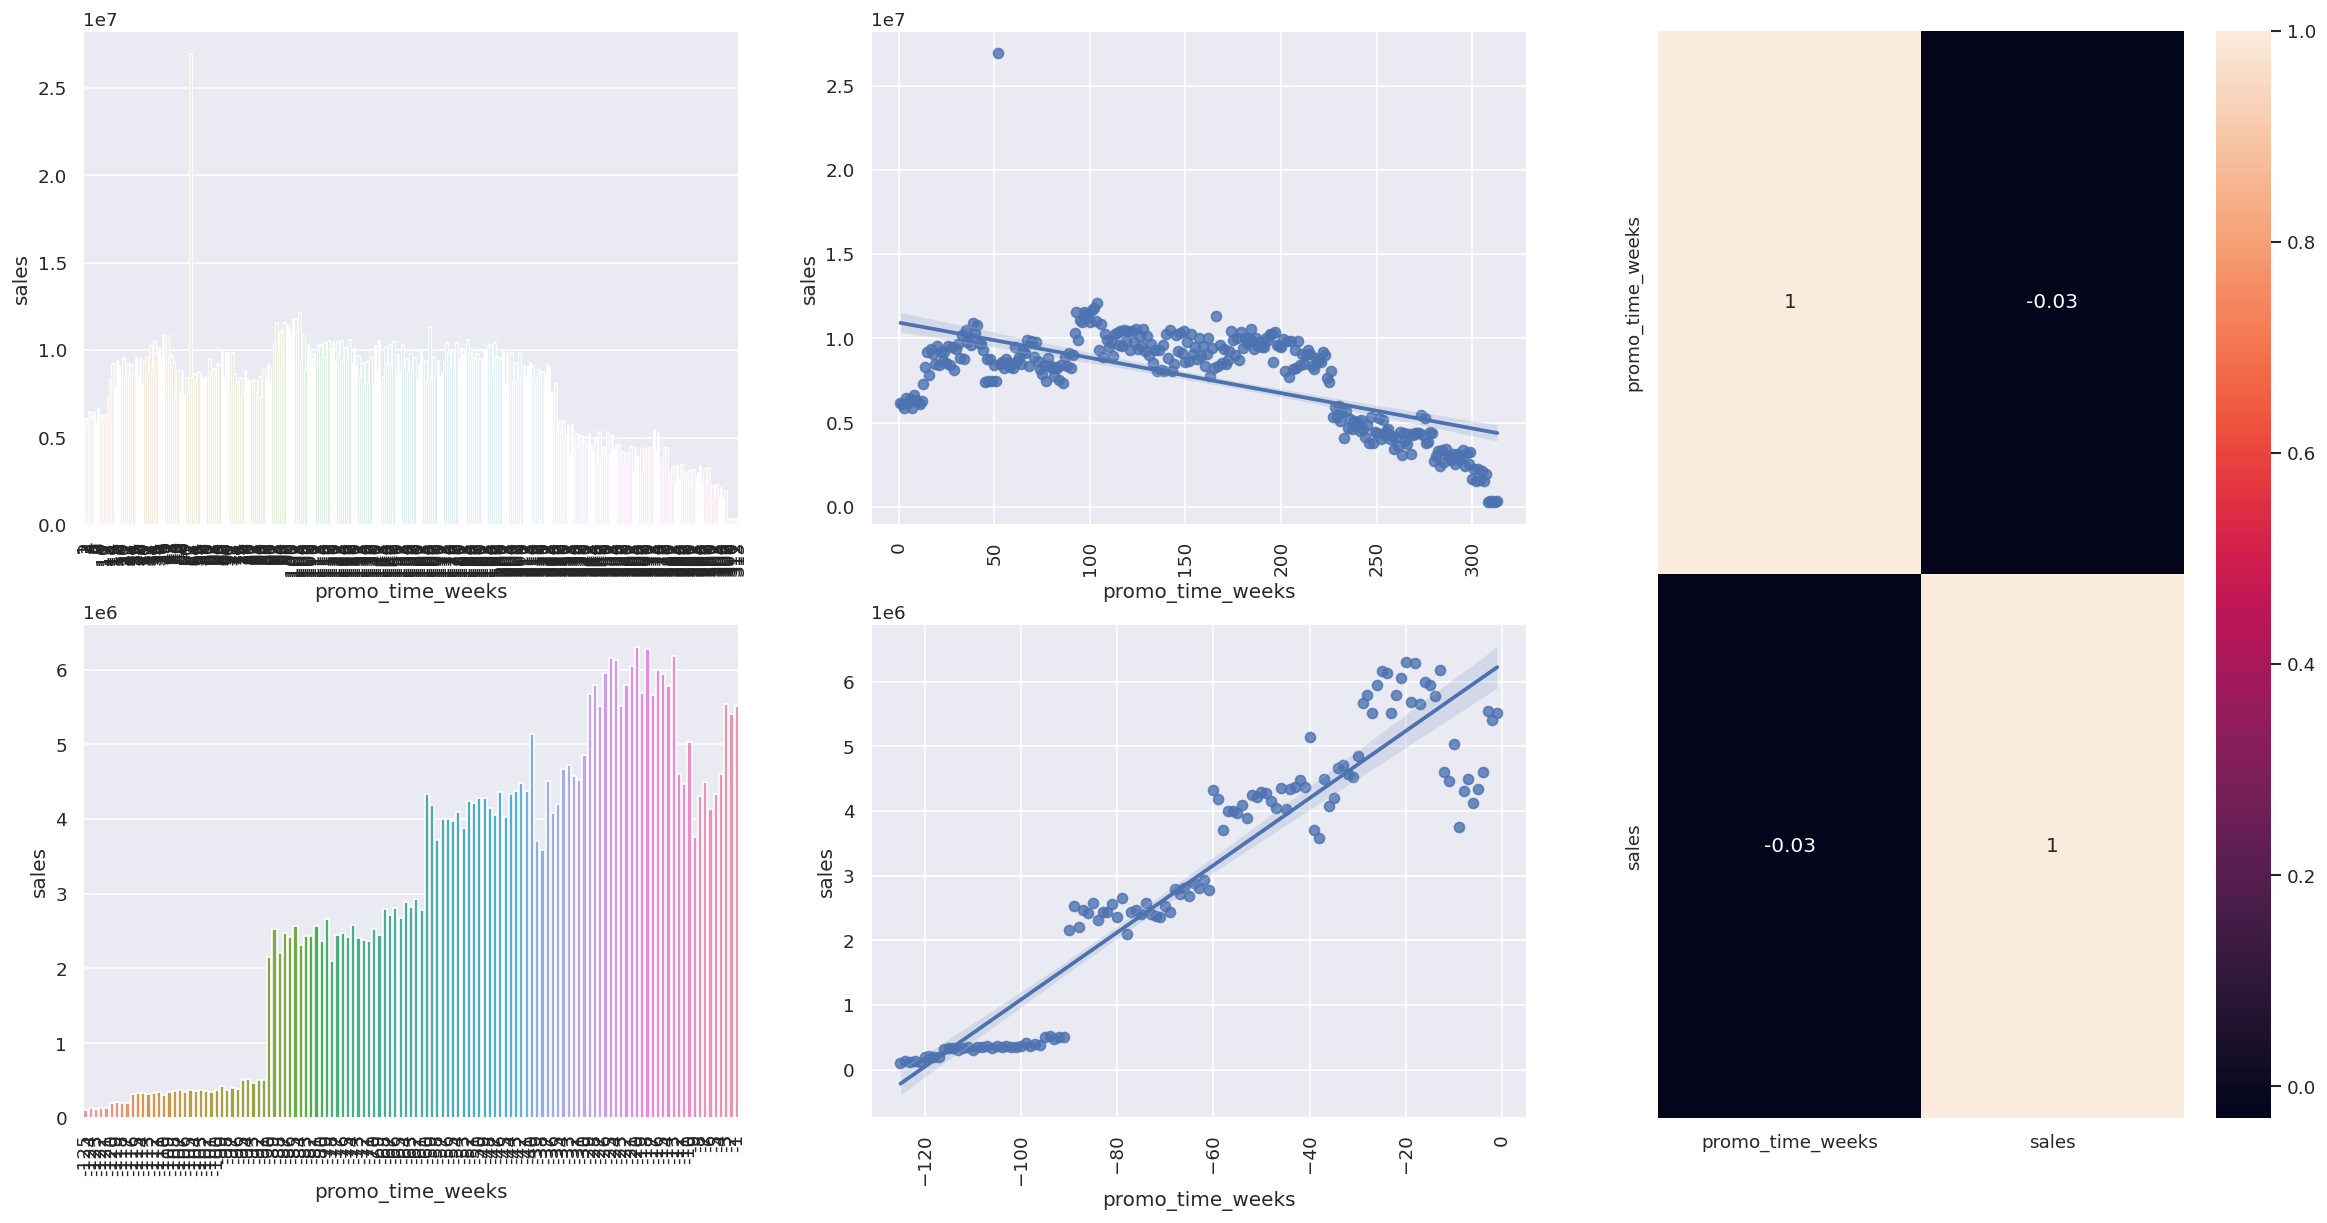

In [24]:
#lojas com promoççoes ativas por mais tempo deveriam vender mais
#falsa: lojas com promoções ativas por mais tempo vendem menos depois de um certo tempo

#promo2 - todos os que não tinham valores foram preenchidos com a data da venda. então 0 é sem promo2
#pormo_time_weeks é a diferença entre a data da venda e quando a promo2 iniciou. 
#se valor der positivo, é pq a venda foi feita nesse periodo de promoção extendida
#se valor der negativo, é pq a venda foi feita antes do periodo de promoção extendida. poderia estar na promocaão normal , ou não estar ainda.

aux1 = df5[['promo_time_weeks', 'sales']].groupby('promo_time_weeks').sum().reset_index()
aux2 = aux1.loc[aux1['promo_time_weeks']> 0] #promo extendida
aux3 = aux1.loc[aux1['promo_time_weeks']< 0] #antes da promo ser extendida

fig = plt.figure(figsize=(24,12))
grid = gridspec.GridSpec (2,3, figure = fig)

plt.subplot(grid[0,0])
sns.barplot(x = 'promo_time_weeks', y = 'sales', data = aux2); #promo extendida
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sns.regplot(x = 'promo_time_weeks', y = 'sales', data = aux2); #promo extendida
plt.xticks(rotation = 90);

plt.subplot(grid[1,0])
sns.barplot(x = 'promo_time_weeks', y = 'sales', data = aux3); #antes da promo ser extendida
plt.xticks(rotation = 90);

plt.subplot(grid[1,1])
sns.regplot(x = 'promo_time_weeks', y = 'sales', data = aux3); #antes da promo ser extendida
plt.xticks(rotation = 90);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'),annot=True);

<AxesSubplot:xlabel='year', ylabel='sales'>

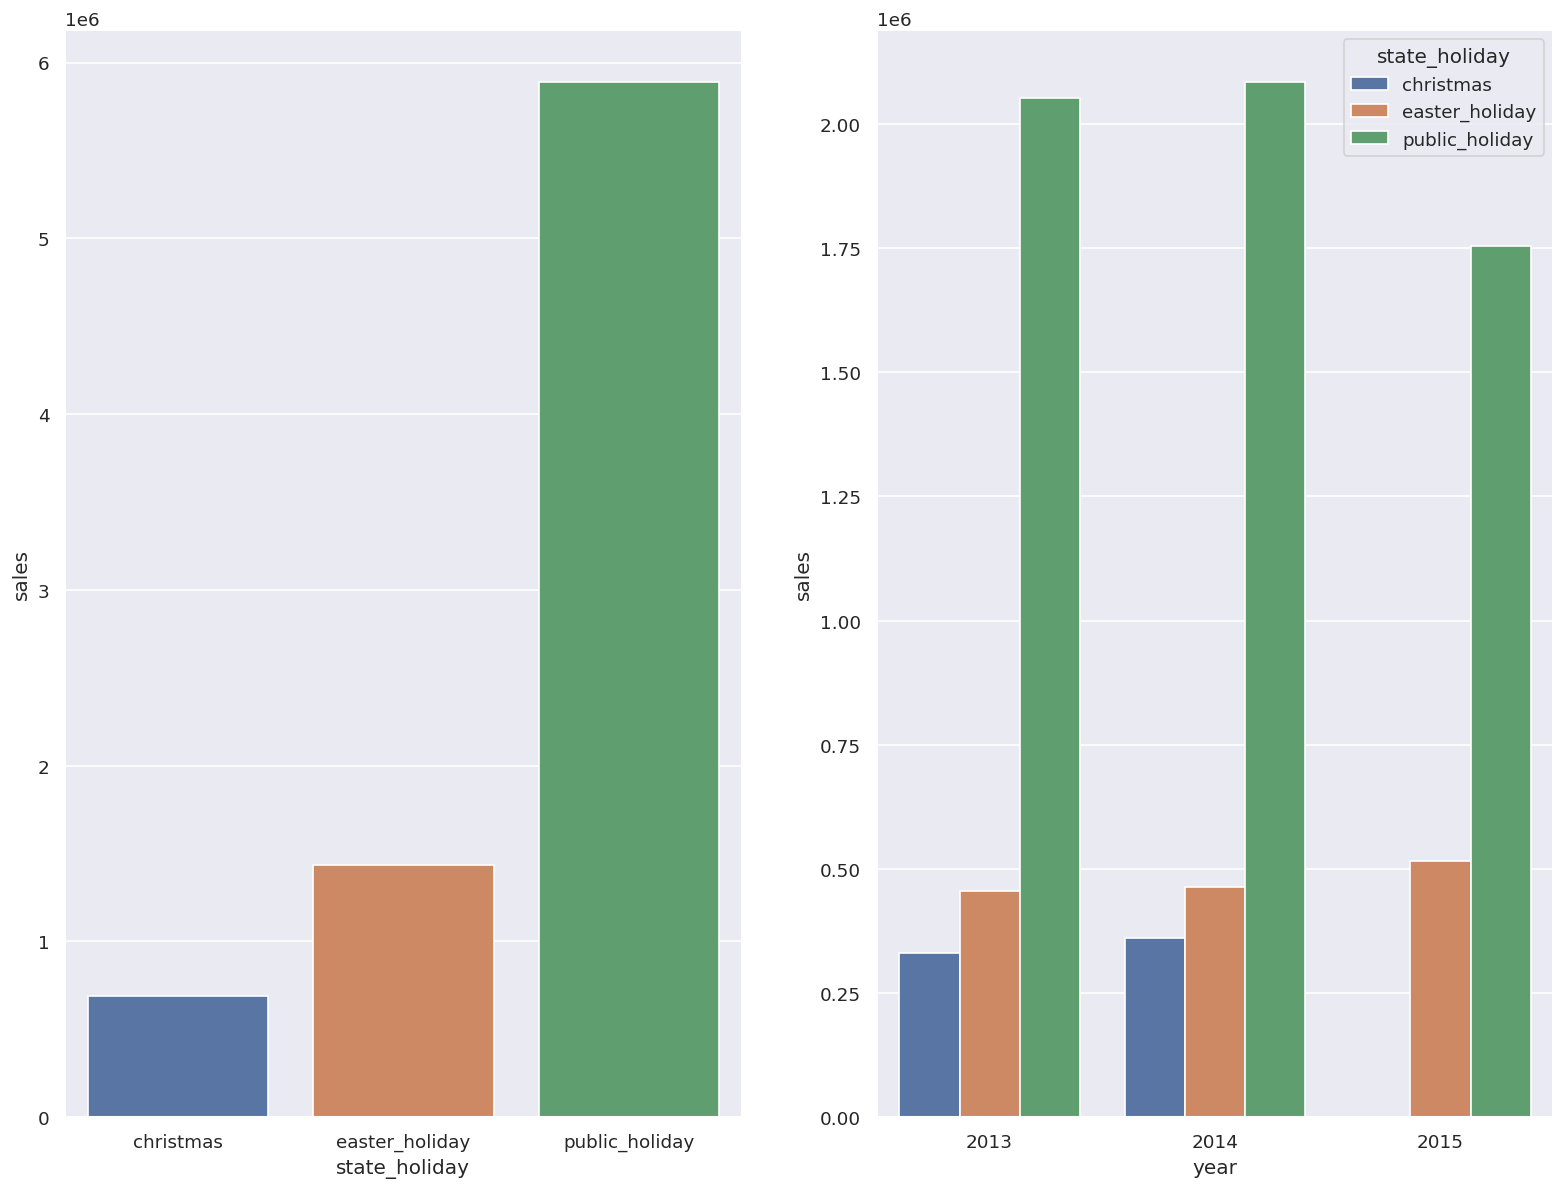

In [25]:
#o feriado com mais vendas é o natal
#falso: o feriado com mais vendas não é o natal

aux1 = df5.loc[df5['state_holiday'] != 'regular_day']
aux2 = aux1[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x ='state_holiday',y ='sales',data = aux2)

aux3 = aux1[['year', 'state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()

plt.subplot(1,2,2)
sns.barplot(x ='year',y ='sales', hue = 'state_holiday',  data = aux3)



##### 

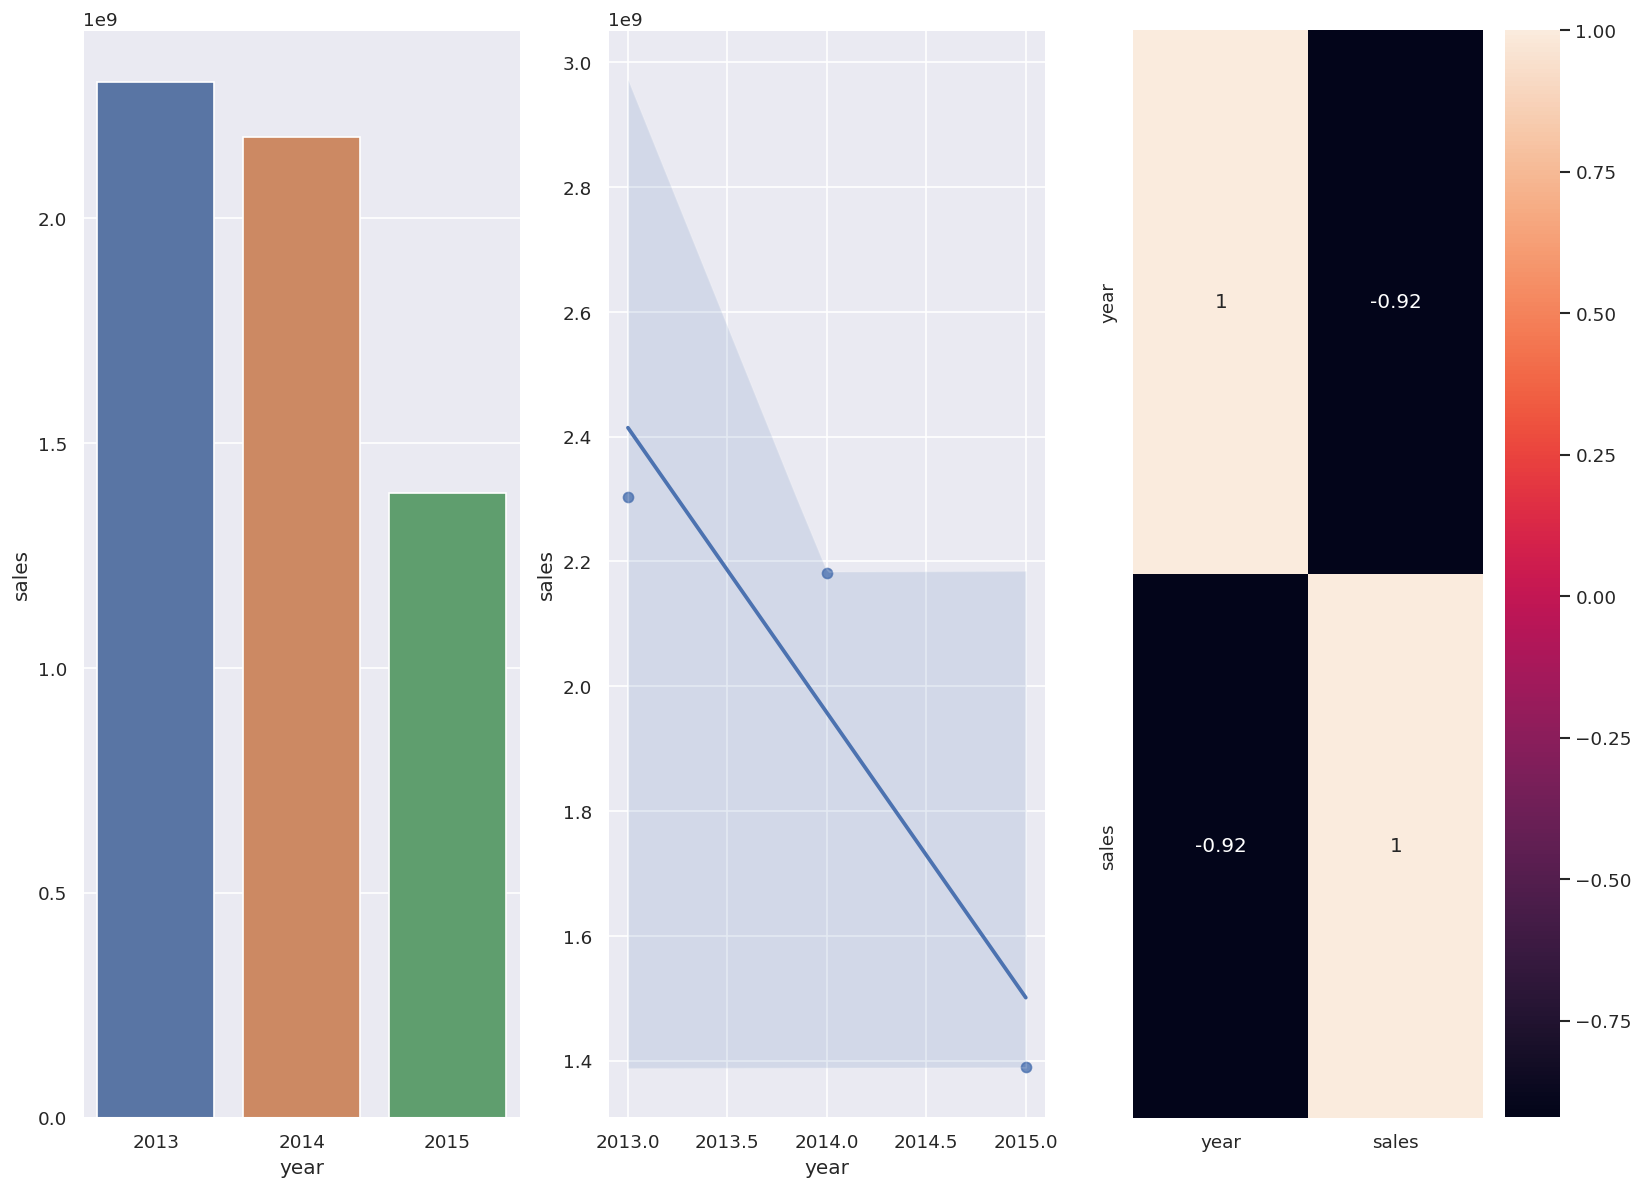

In [26]:
#lojas deveriam vender mais ao longo dos anos
#falso: lojas vendem menos ao longo dos anos

aux1 = df5[['sales', 'year']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year' , y='sales' , data =aux1 );

plt.subplot(1,3,2)
sns.regplot(x='year' , y='sales' , data =aux1 );

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True);


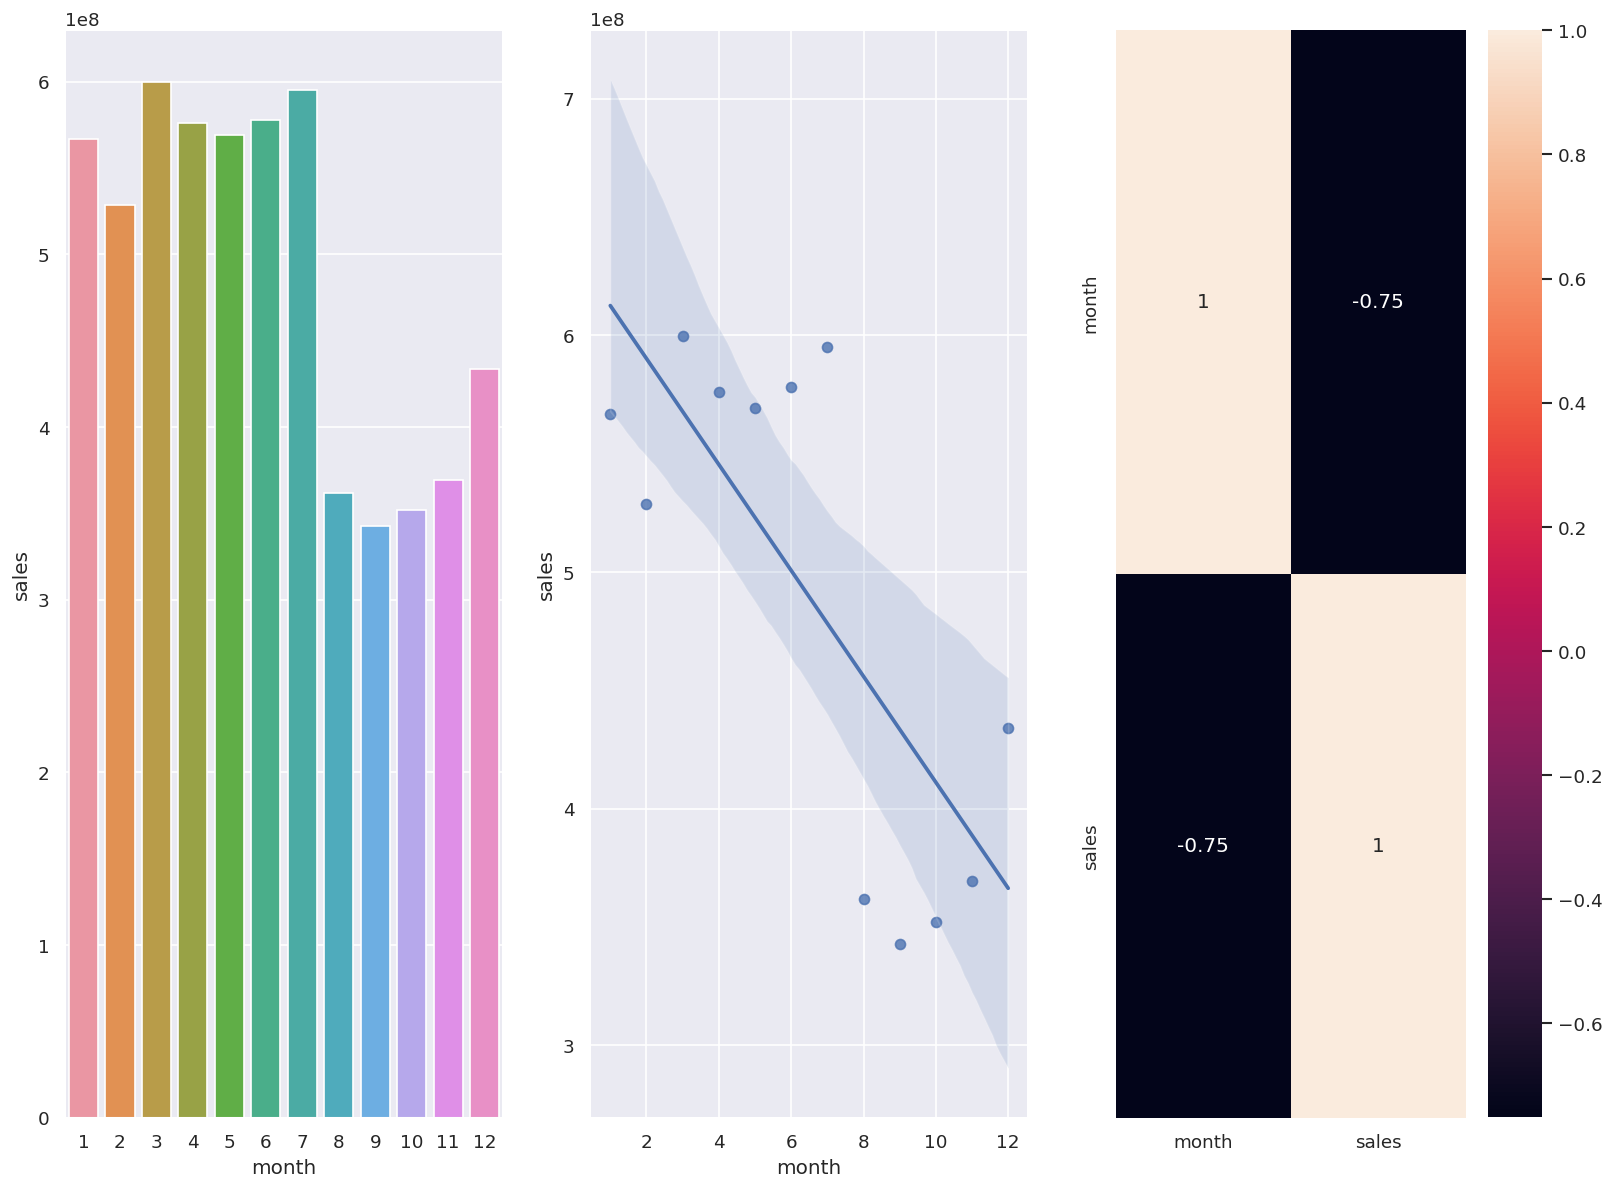

In [27]:
#lojas vendem mais no segundo semestre do ano
#falso: lojas vendem menos no segundo semestre do ano

aux1 = df5[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month' ,y = 'sales', data= aux1)

plt.subplot(1,3,2)
sns.regplot(x='month' , y='sales' , data =aux1 );

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True);



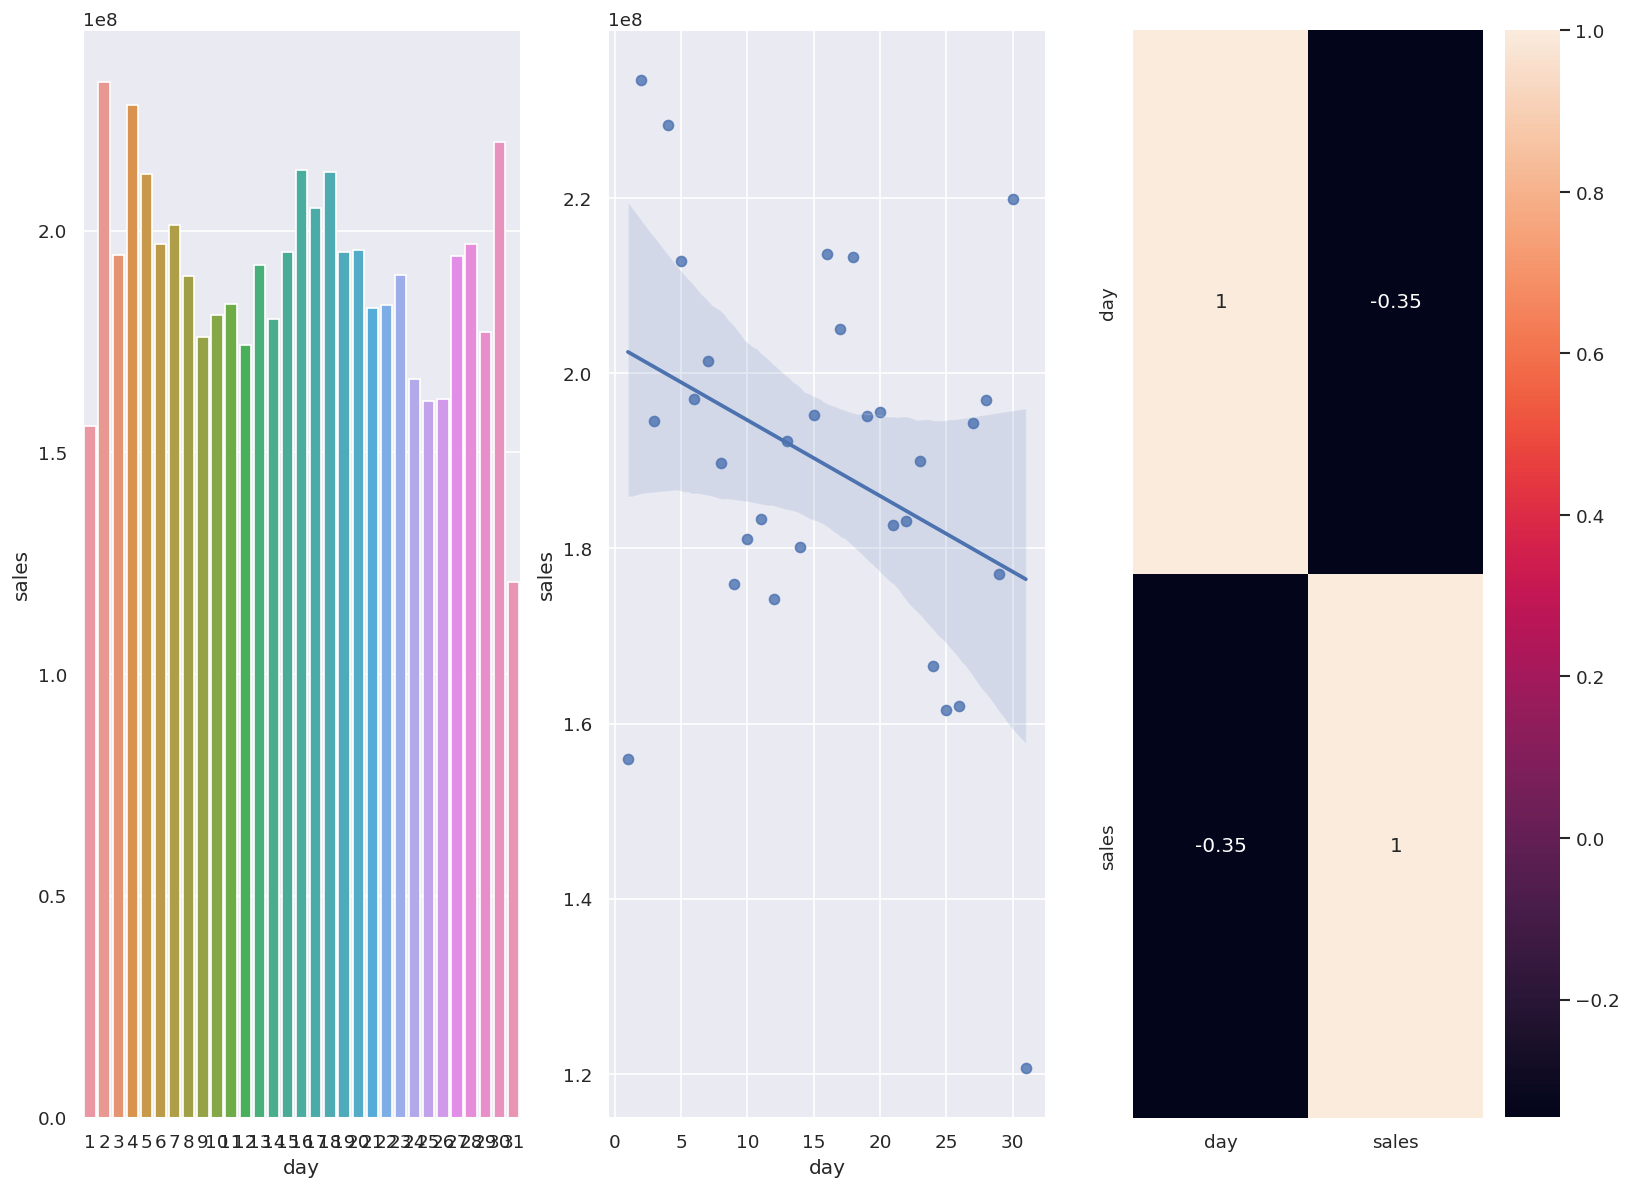

In [28]:
#lojas deveriam vender mais conforme o mes vai passando
#falso: lojas vendem menos conforme o mes vai passando
aux1 = df5[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day' ,y = 'sales', data= aux1)

plt.subplot(1,3,2)
sns.regplot(x='day' , y='sales' , data =aux1 );

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True);




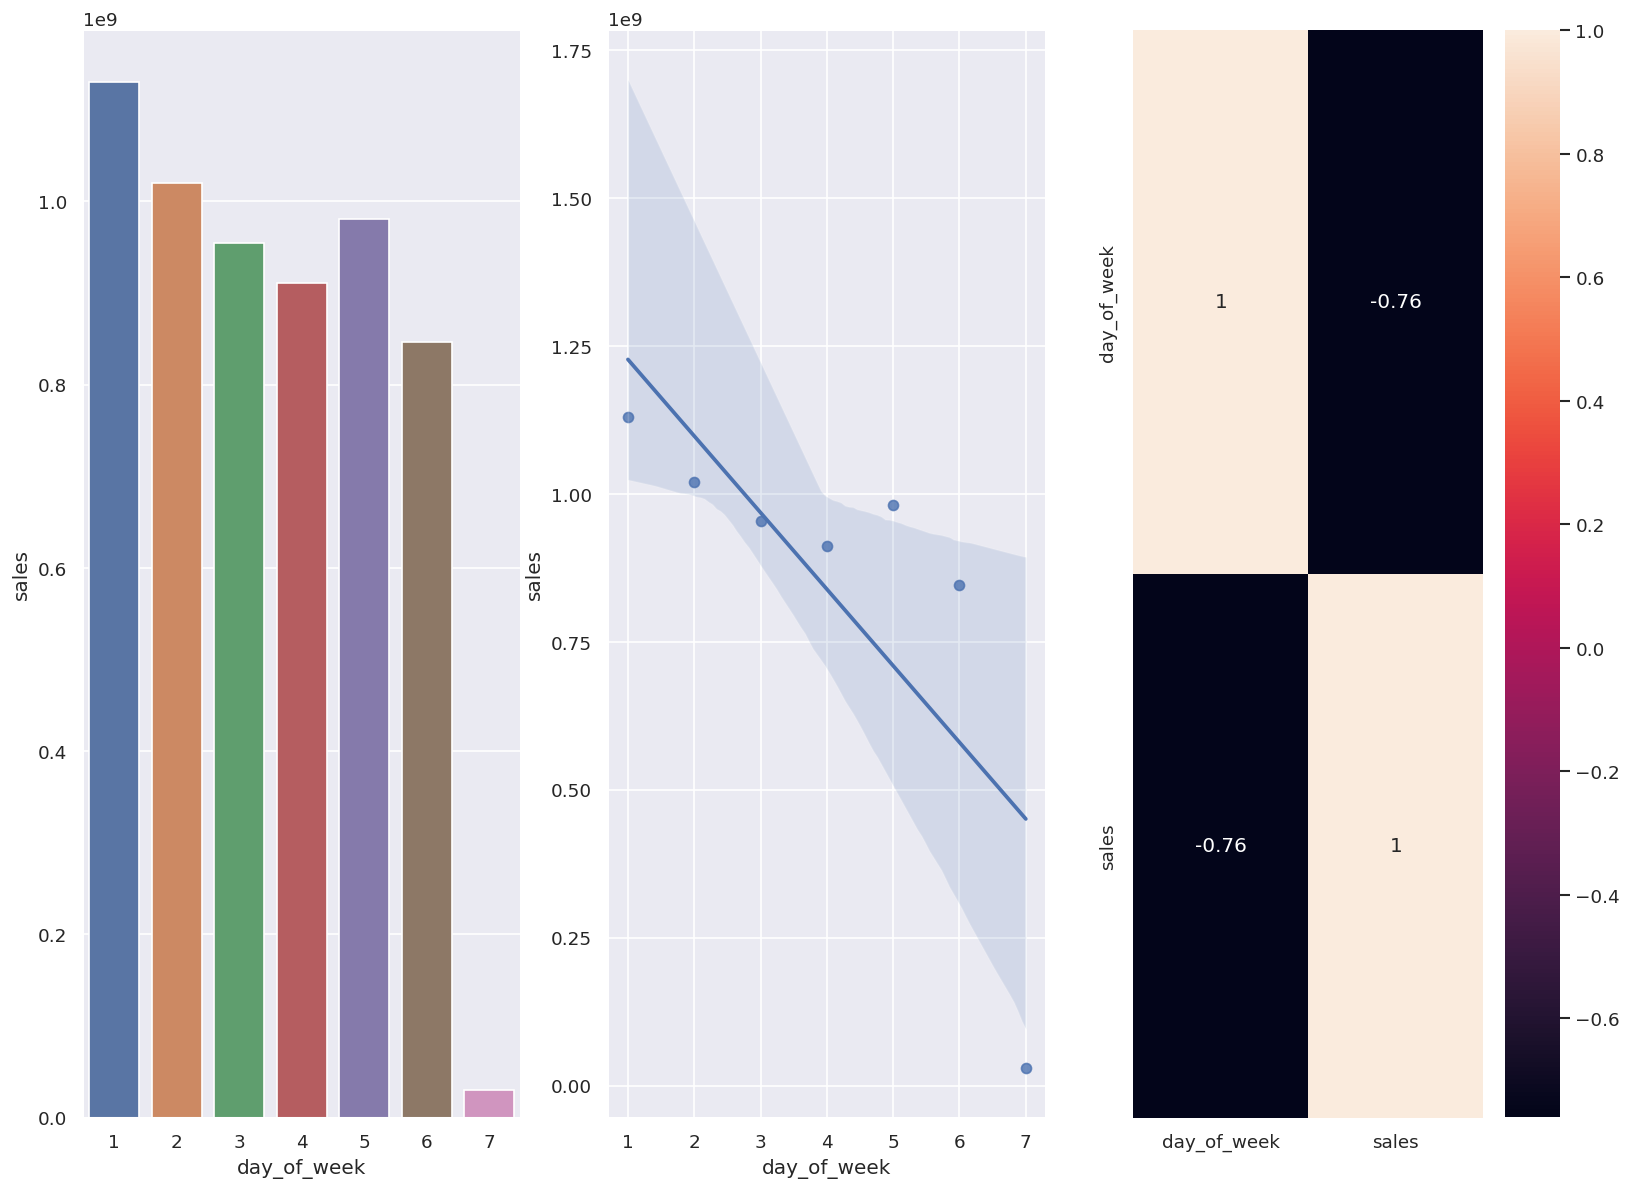

In [29]:
#lojas deveriam vender menos nos finais de semana
#verdadeiro: lojas vendem menos nos finais de semana

aux1 = df5[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week' ,y = 'sales', data= aux1)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week' , y='sales' , data =aux1 );

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True);


<AxesSubplot:xlabel='month', ylabel='sales'>

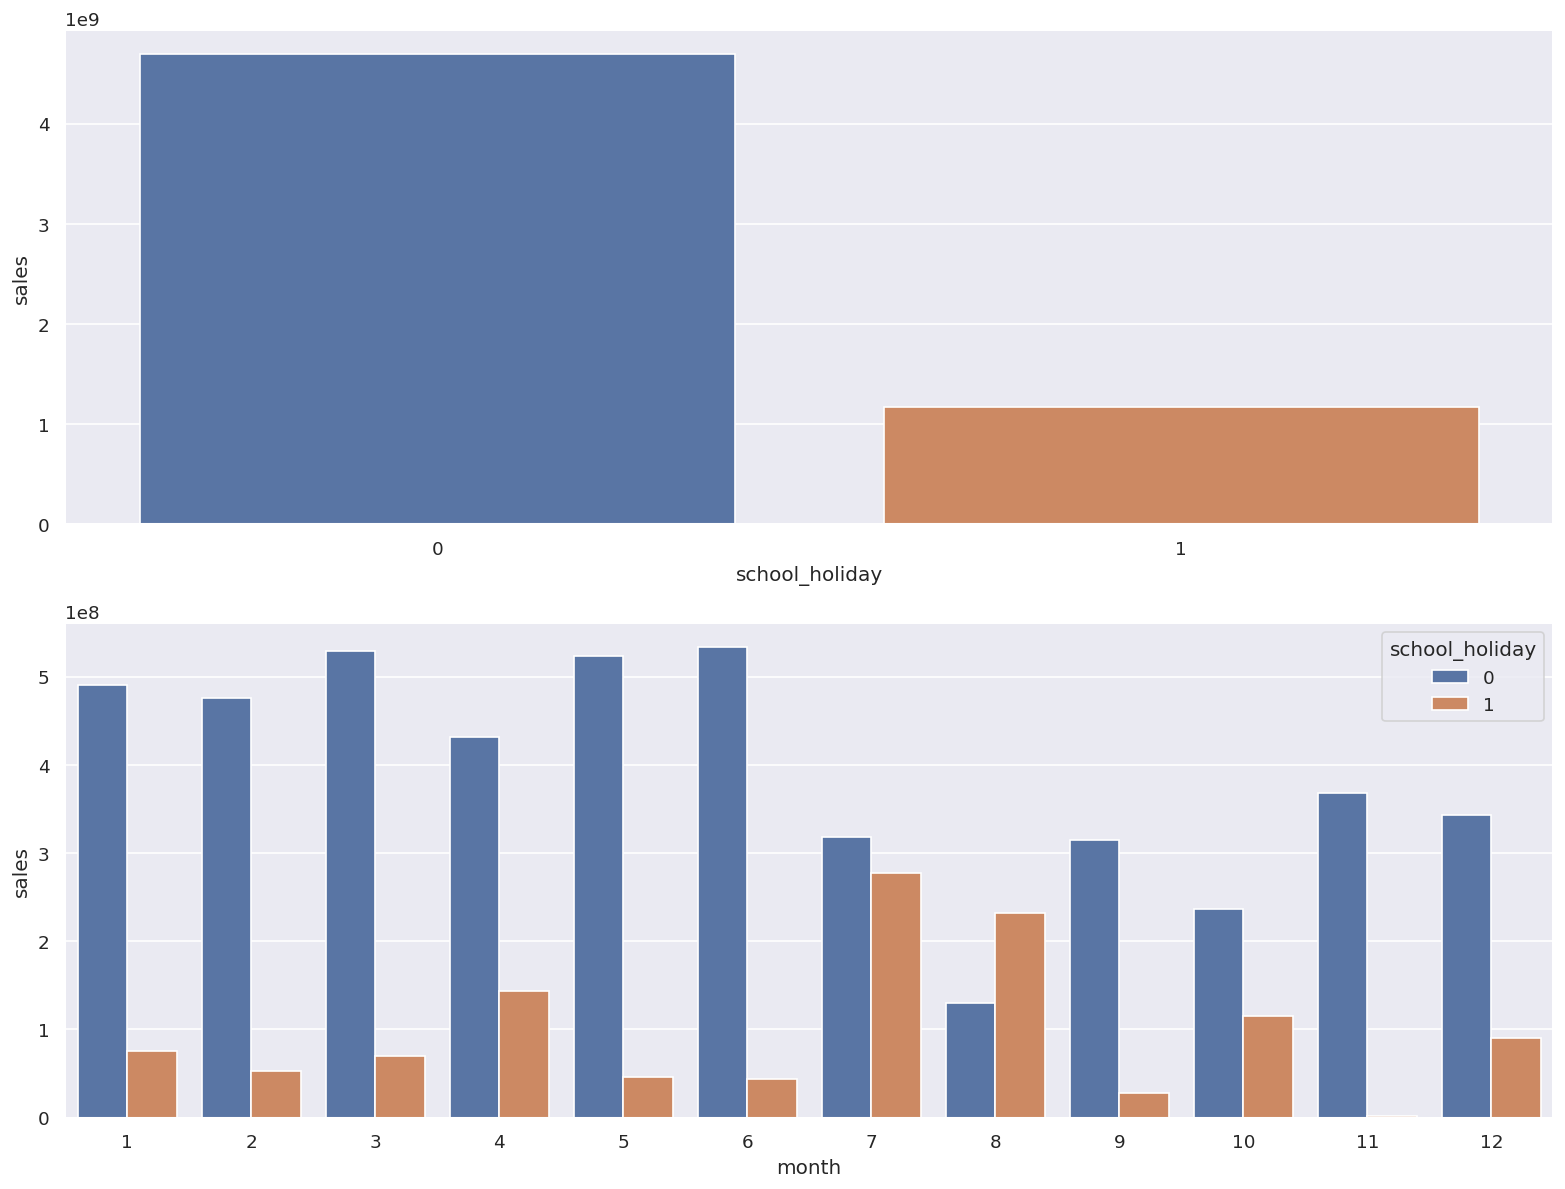

In [30]:
#lojas deveriam vender menos durante feriados escolares
#verdadeiro:lojas vendem menos durando os feriados escolares, exceto no mes agosto

plt.subplot(2,1,1)
aux1 = df5[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1)

plt.subplot(2,1,2)
aux2 = df5[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x = 'month', y = 'sales', hue = 'school_holiday', data = aux2)




In [31]:
#Análise Multivariada
#correlações entre as variaveis
#quanto maior o numero de colunas do dataset, mais complexo é o modelo
#pra diminuir complexidade, retira colunas que tragam informações repetidas - variaveis muito correlacionadas
#escolher modelos de menor complexidade



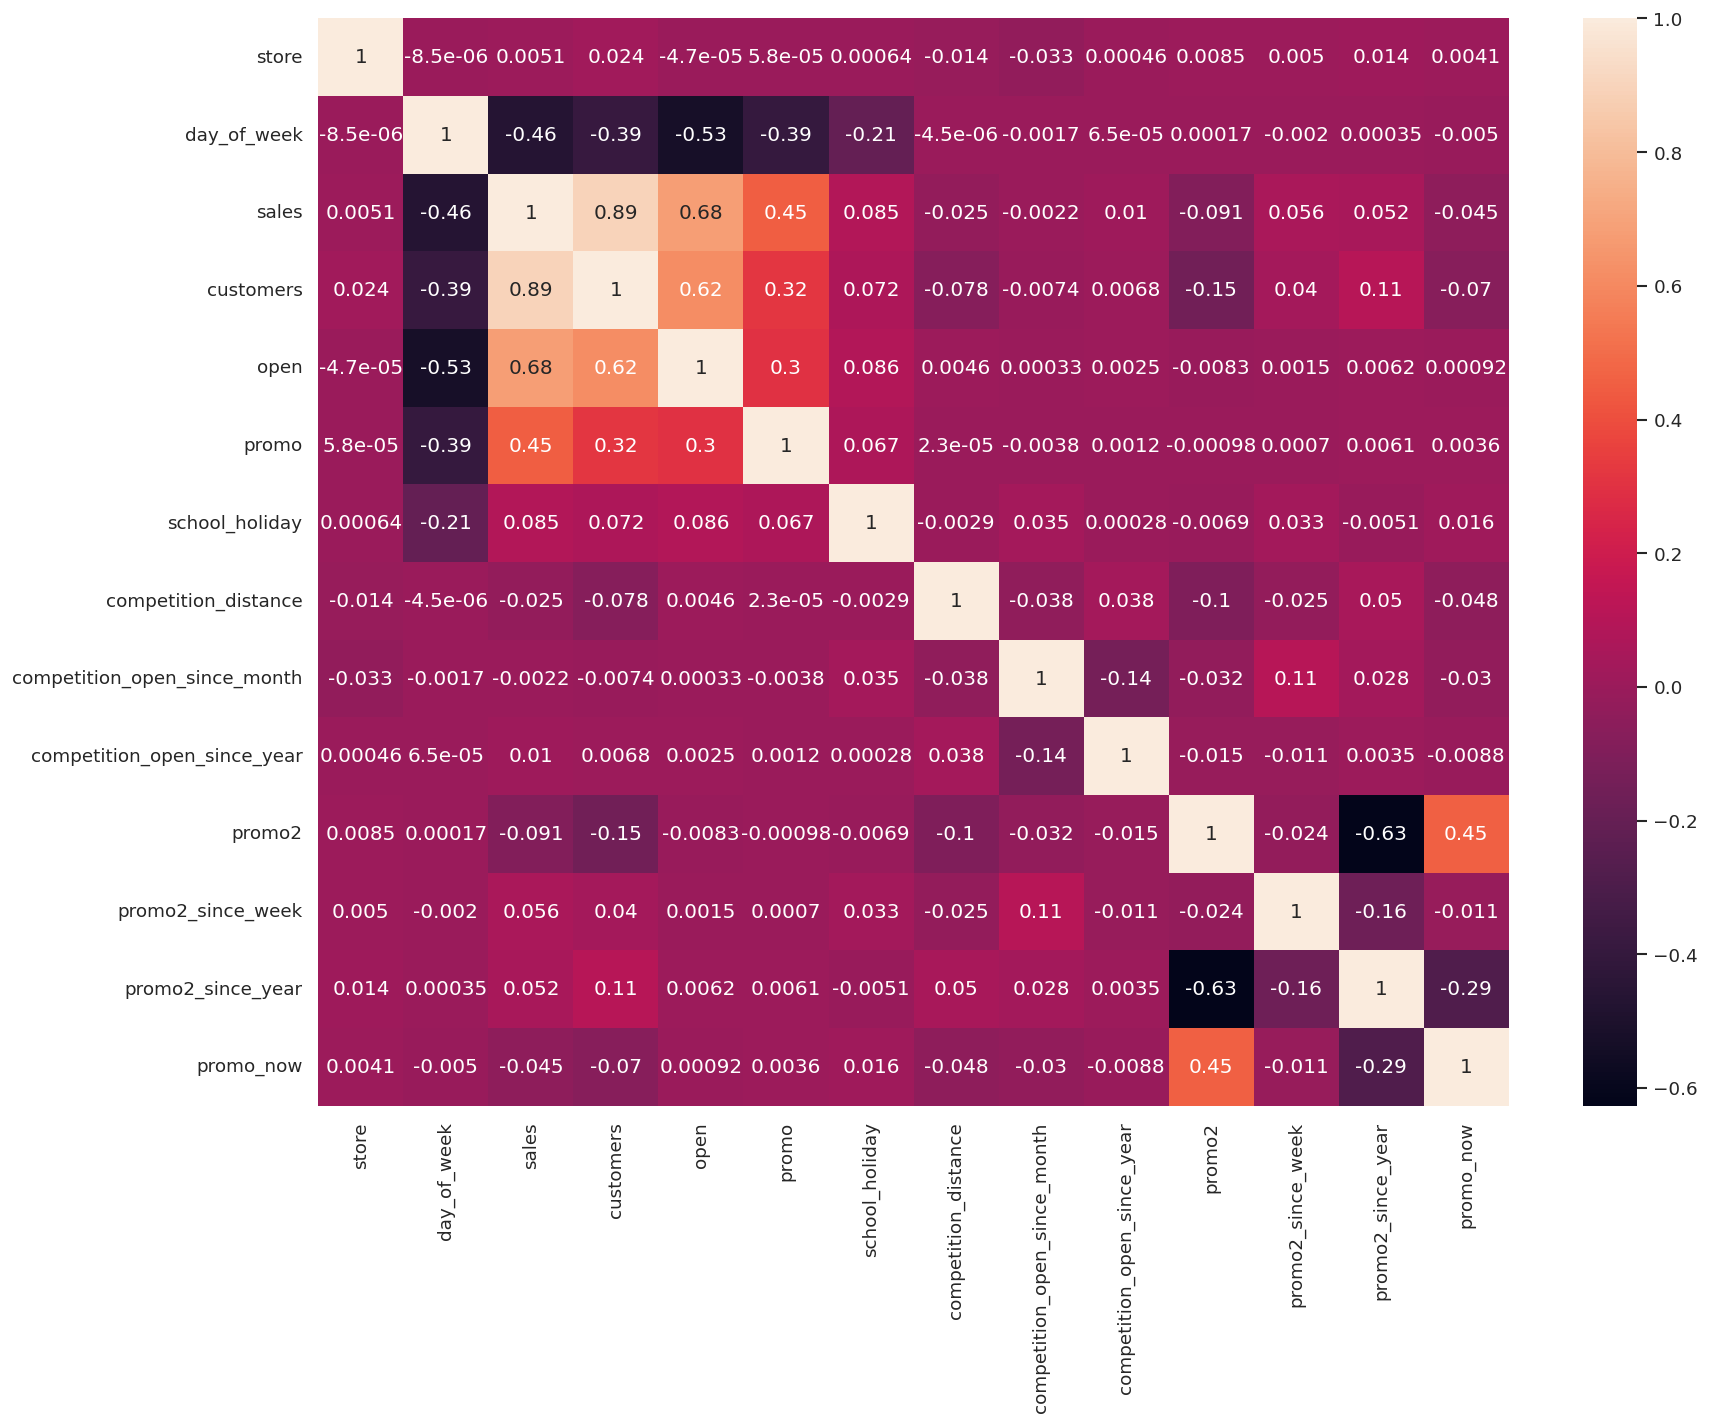

In [32]:
#numerical attributes
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

<AxesSubplot:>

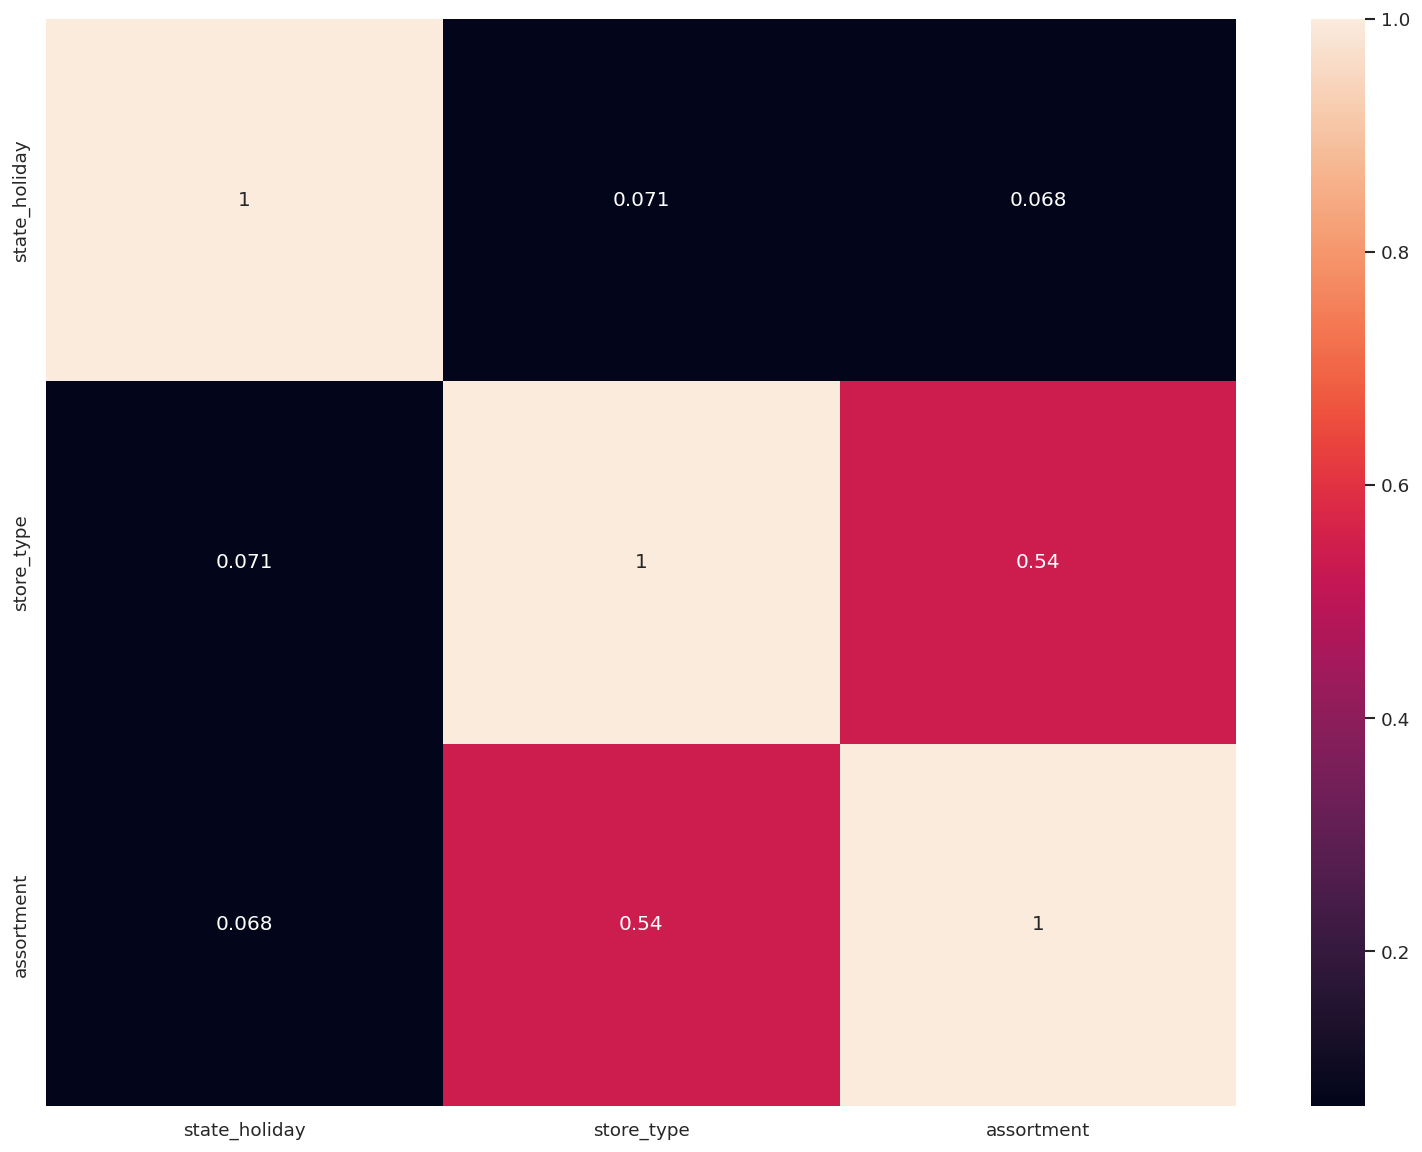

In [61]:
#filter categorical data
b = df5.select_dtypes(include = 'object')

#calculate cramer v
a1 = cramer_v(b['state_holiday'], b['state_holiday'])
a2 = cramer_v(b['state_holiday'], b['store_type'])
a3 = cramer_v(b['state_holiday'], b['assortment'])

a4 = cramer_v(b['store_type'], b['state_holiday'])
a5 = cramer_v(b['store_type'], b['store_type'])
a6 = cramer_v(b['store_type'], b['assortment'])

a7 = cramer_v(b['assortment'], b['state_holiday'])
a8 = cramer_v(b['assortment'], b['store_type'])
a9 = cramer_v(b['assortment'], b['assortment'])

d = pd.DataFrame({'state_holiday': [a1,a2,a3], 
              'store_type': [a4,a5,a6],
              'assortment': [a7,a8,a9] })

#final dataset
d = d.set_index(d.columns)
sns.heatmap(d, annot = True)

In [83]:
#normalizalção
#não há variaveis com comportamento normal, portanto esta não usaremos normalização

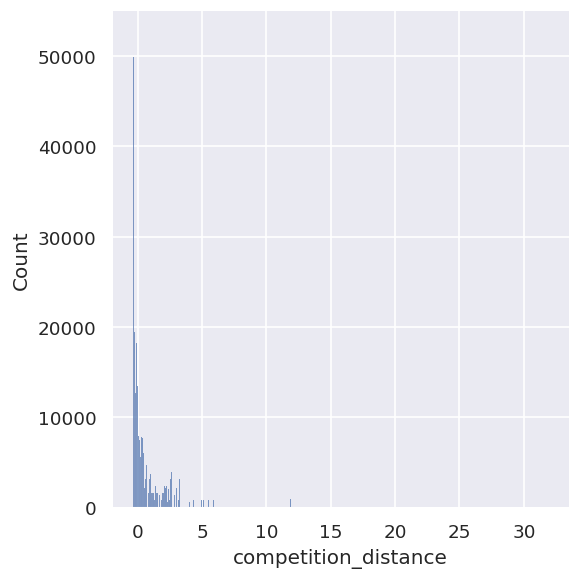

In [116]:
#rescaling
df6  = df5.copy()
rs = RobustScaler()
mms = MinMaxScaler()

#competition_distance
df6['competition_distance'] = rs.fit_transform(df6[['competition_distance']].values)
#competition_time_month
df6['competition_time_month'] = rs.fit_transform(df6[['competition_time_month']].values)
#promo_time_weeks
df6['promo_time_weeks'] = mms.fit_transform(df6[['promo_time_weeks']].values)
#year
df6['year'] = mms.fit_transform(df6[['year']].values)

sns.displot(df6['competition_distance']);

In [110]:
DATA PREPARING - ENCODING

In [117]:
#state_holiday
#one hot encoding
df6 = pd.get_dummies(df6, prefix=['state_holiday'], columns = ['state_holiday'])

#store_type
#label encoding
le = LabelEncoder()
df6['store_type'] = le.fit_transform(df6['store_type'])

#assortment
#ordinal encoding
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df6['assortment'] = df6['assortment'].map(assortment_dict)

DATA PREPARING - TRANFORMAÇÃO DE GRANDEZA

In [119]:
#transformação de grandeza:
#transforma o comportamento das variavel resposta o mais próximos de uma distribuição normal. transforma variaveis com skew muito a direita ou esquerda mais proximas da normal
    #tranformação logaritimica: 
    #box-cox transformation: formula 
    #cube-root tranformation: extrai raiz cubica dos valores
    #square root: extrai raiz de todos os valores
    
#tranformação de natureza:
#tranforma os dados na sua natureza. exemplo: ciclo - mes de 1 a 12 : mostrar que 1 vem depois de 12


In [120]:
#response variable transformation

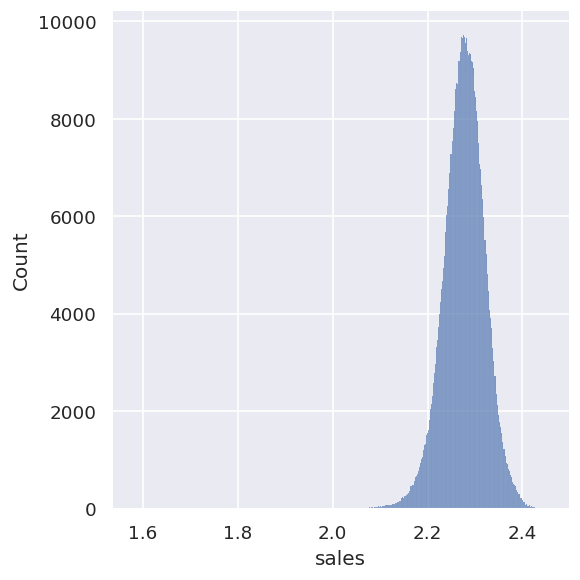

In [122]:
df6['sales'] = np.log1p(df6['sales'])
sns.displot(df6['sales']);

In [ ]:
#nature tranformation
#day of week
#month
#day
#week of year


In [126]:
#day_of_week
df6['day_of_week_sin'] = df6['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df6['day_of_week_cos'] = df6['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

#month
df6['month_sin'] = df6['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df6['month_cos'] = df6['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

#day
df6['day_sin'] = df6['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df6['day_cos'] = df6['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

#week of year
df6['week_of_year_sin'] = df6['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df6['week_of_year_cos'] = df6['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

In [127]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,promo_now,year,month,day,week_of_year,year_week,competition_time_month,promo_time_weeks,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,2.258492,1,1,2,1,-0.170968,9,2008,0,31,2015,0,0,1.0,7,31,31,2015-30,0.918919,0.285388,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984
1,2,5,2015-07-31,2.273186,1,1,0,1,-0.283871,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",1,1.0,7,31,31,2015-30,1.054054,0.922374,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984
2,3,5,2015-07-31,2.305163,1,1,0,1,1.903226,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",1,1.0,7,31,31,2015-30,1.202703,0.801370,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984
3,4,5,2015-07-31,2.355797,1,1,2,3,-0.275806,9,2009,0,31,2015,0,0,1.0,7,31,31,2015-30,0.743243,0.285388,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984
4,5,5,2015-07-31,2.249306,1,1,0,1,4.448387,4,2015,0,31,2015,0,0,1.0,7,31,31,2015-30,-0.162162,0.285388,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.974928,-0.222521,-0.568065,-0.822984
